## As we've been digging in to try and understand the correlation coefficients between surface fluxes and mean wind speeds/variances, it's come up that it might be better to try looking at individual sites and timeseries. 
So this will involve FLUXNET sites in particular to try and get a feel for which synoptic conditions are really hard for the model to get right, and/or which ones tend to lead to negative vs. positive correlations between wind speeds and surface fluxes. <br><br>
<b>Date:</b> 3 Dec 2020

In [1]:
# Load libraries

# Plotting utils 
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import matplotlib.ticker as ticker 
import matplotlib.patches as patches
import matplotlib.animation as animation
import matplotlib as matplotlib
import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.util

# Analysis
import os
import numpy as np 
import xarray as xr
import datetime
from   datetime import date, timedelta
import pandas as pd 
#import regionmask
import pickle
import scipy.stats as stats
import glob


In [2]:
import warnings
warnings.filterwarnings('once')

## 1. Read in FLUXNET data (and filter out a few stations based on length of record)

In [3]:
# --------------------------------------
# Define data directory: 
# --------------------------------------
fluxnetDir   = '/Users/mdfowler/Documents/Analysis/Coupling_initial/data/FLUXNET2015/'

# --------------------------------------
# Get general site info
# --------------------------------------
siteInfoFile = fluxnetDir+'SiteList.csv'
# Now read that CSV file into a pandas dataframe 
siteInfoDF = pd.read_csv(siteInfoFile)

# Print out information available:
print('Available site characteristics (metadata) include: \n\n', siteInfoDF.columns.values, '\n')

# --------------------------------------
# And read in metadata for good measure
# --------------------------------------
metadataFile = fluxnetDir+'FLX_AA-Flx_BIF_ALL_20200501/FLX_AA-Flx_BIF_DD_20200501.xlsx'

# Read in that file 
metadataDF = pd.read_excel(metadataFile)


/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Available site characteristics (metadata) include: 

 ['SITE_ID' 'SITE_NAME' 'FLUXNET2015' 'FLUXNET-CH4' 'LOCATION_LAT'
 'LOCATION_LONG' 'LOCATION_ELEV' 'IGBP' 'MAT' 'MAP'] 



In [4]:
# --------------------------------------
# Get a list of all fluxnet data files
# --------------------------------------
dataFiles = glob.glob(fluxnetDir + 'FLX_*/*SUBSET_DD*')


In [5]:
# ------------------------------------------
# Define a function to read in FLUXNET data 
# ------------------------------------------

# --------------------------------------------------------
# Function to read requested variables from FLUXNET file. 
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
# 
# Inputs:  fileName --> Full path to FLUXNET data file 
#          varNames --> An array of variable names to be 
#                       retrieved from said data file. 
#                       NOTE: If you wish to retrieve *all* 
#                       variables, pass the string 'ALL'. 
#          Note: varInfo found here
#                https://fluxnet.org/data/fluxnet2015-dataset/subset-data-product/
#  
# Outputs: fluxnetID --> ID string used to identify station
#          fluxnetDS --> An x-array dataset containing the 
#                        requested variables.
#                        Missing values will be set to NaN. 
# 
# --------------------------------------------------------

def readFLUXNET_var(fileName, varNames): 
    # Get ID of station 
    startID   = fileName.find('FLX_')
    fluxnetID = fileName[startID+4:startID+10]
    
    # print('Reading in site - ', fluxnetID)
    
    # Read in CSV file containing data 
    dataDF = pd.read_csv(fileName)
    
    # Return ALL variables from dataDF if requested
    if varNames=='ALL':
        fluxnetDF = dataDF
        
        # Set any value that's missing to NaN (not -999)
        fluxnetDF = fluxnetDF.replace(-9999, np.nan)

        
        # If time has been requested, reformat to pandas make index
        fluxnetDF['TIMESTAMP'] = pd.to_datetime(fluxnetDF['TIMESTAMP'].values, format='%Y%m%d')
        fluxnetDF = fluxnetDF.set_index(['TIMESTAMP'])
        
        # Convert dataframe to Xarray Dataset (required to use coupling metrics toolbox)
        fluxnetDS = fluxnetDF.to_xarray()
            
    # Reduce returned DF to contain only variables of interest  
    else:
        
        # Check that requested variables are available in specific file
        errCount = 0                       # Initialize flag for error 
        colNames = dataDF.columns.values   # Available variables in file 
        
        for iVar in range(len(varNames)):  # Check each variable individually
            if (varNames[iVar] in colNames)==False:
                # Turn on print statement for more verbose output
                # print('** ERROR: %13s   not contained in file for %8s  **' %(varNames[iVar], fluxnetID))
                
                # If any variable is not conatined in file, return a NaN 
                fluxnetDS = -999
                errCount  = errCount+1
                
        # If all the variables *are* available, isolate those in DF and return that
        if errCount == 0: 
            fluxnetDF = dataDF[varNames]
            
            # Set any value that's missing to NaN (not -999)
            fluxnetDF = fluxnetDF.replace(-9999, np.nan)
            
            # If time has been requested, reformat to pandas make index
            if ('TIMESTAMP' in varNames)==True:
                fluxnetDF['TIMESTAMP'] = pd.to_datetime(fluxnetDF['TIMESTAMP'].values, format='%Y%m%d')
                fluxnetDF = fluxnetDF.set_index(['TIMESTAMP'])
        
            # Convert dataframe to Xarray Dataset (required to use coupling metrics toolbox)
            fluxnetDS = fluxnetDF.to_xarray()
    
    return(fluxnetID, fluxnetDS)


### 1.1 First find out total period spanned by FLUXNET data 
This will help define empty arrays that can be filled properly for each station individually, leaving NaNs on days that don't have data per station. 

In [6]:
# Define emtpy arrays to save stuff into 
startTime_fluxnet = np.full([len(dataFiles)], np.nan)
endTime_fluxnet   = np.full([len(dataFiles)], np.nan)
nMonths_fluxnet   = np.full([len(dataFiles)], np.nan)
# allStationID      = np.empty([len(dataFiles)]).astype(str)

# Variables I want returned:
varNames = ['TIMESTAMP','H_F_MDS','LE_F_MDS','WS_F','P_F','PA_F','TA_F']

# Loop over each station (data file)
for iStation in range(len(dataFiles)): 
    
    # Read in data 
    # ----------------------------------------------------------
    fluxnetID,fluxnetDS = readFLUXNET_var(dataFiles[iStation], varNames)
#     allStationID[iStation] = fluxnetID
    
    # Save lat and lon for this station 
    # ----------------------------------------------------------
    indStation  = np.where(fluxnetID==siteInfoDF['SITE_ID'])
    lat_fluxnet = siteInfoDF['LOCATION_LAT'].values[indStation]
    lon_fluxnet = siteInfoDF['LOCATION_LONG'].values[indStation]
    
    # Check that there was data saved for this particular site: 
    # ----------------------------------------------------------
    if (type(fluxnetDS)==int):
        print('No data for station: %8s' % fluxnetID)
    
    elif ( (np.all(np.isnan(fluxnetDS['H_F_MDS']))==True) | (np.all(np.isnan(fluxnetDS['WS_F']))==True) | (np.all(np.isnan(fluxnetDS['LE_F_MDS']))==True) ):
        print('No data for station: %8s' % fluxnetID)
        
    # If data is present: 
    # ----------------------------------------------------------
    else:        
        # Only consider where data is actually present for selected vars
        iReal      = np.where((np.isfinite(fluxnetDS['LE_F_MDS'])==True) & 
                              (np.isfinite(fluxnetDS['H_F_MDS'])==True) & 
                              (np.isfinite(fluxnetDS['WS_F'])==True) & 
                              (np.isfinite(fluxnetDS['P_F'])==True) &
                              (np.isfinite(fluxnetDS['PA_F'])==True) &   
                              (np.isfinite(fluxnetDS['TA_F'])==True))[0]
        fluxnetDS  = fluxnetDS.isel(TIMESTAMP=iReal)
        
        # Check how long data is available for and isolate JJA 
        # -----------------------------------------------------------
        startTime_fluxnet[iStation]  = fluxnetDS['TIMESTAMP'].values[0]
        endTime_fluxnet[iStation]    = fluxnetDS['TIMESTAMP'].values[-1]
        
        dateRange = pd.date_range(start=startTime_fluxnet[iStation],end=endTime_fluxnet[iStation],freq='M')
        nMonths_fluxnet[iStation] = len(dateRange)
        

In [7]:
# Check how many/which stations have enough years of data to be used, then
#    print some useful information on all that and 

iMinStart = np.where(startTime_fluxnet==np.nanmin(startTime_fluxnet))[0]
iMaxEnd   = np.where(endTime_fluxnet==np.nanmax(endTime_fluxnet))[0]

limYears = 5 
iStation_limYears = np.where(nMonths_fluxnet>=limYears*12)[0]

print('Number of stations with at least 5 years of data: ', len(iStation_limYears))
print()

print('Looking at every station available...')
print('Earliest start of data:    ', pd.DatetimeIndex(startTime_fluxnet[iMinStart])[0] )
print('Latest end of data:        ', pd.DatetimeIndex(endTime_fluxnet[iMaxEnd])[0] )

print()
del iMinStart
del iMaxEnd

startTime_fluxnet_sel = startTime_fluxnet[iStation_limYears]
endTime_fluxnet_sel   = endTime_fluxnet[iStation_limYears]

iMinStart = np.where(startTime_fluxnet_sel==np.nanmin(startTime_fluxnet_sel))[0]
iMaxEnd   = np.where(endTime_fluxnet_sel==np.nanmax(endTime_fluxnet_sel))[0]
print('Of stations with at least 5 years of data...')
print('Earliest start of data:    ', pd.DatetimeIndex(startTime_fluxnet_sel[iMinStart])[0] )
print('Latest end of data:        ', pd.DatetimeIndex(endTime_fluxnet_sel[iMaxEnd])[0] )


Number of stations with at least 5 years of data:  116

Looking at every station available...
Earliest start of data:     1991-01-01 00:00:00
Latest end of data:         2014-12-31 00:00:00

Of stations with at least 5 years of data...
Earliest start of data:     1991-01-01 00:00:00
Latest end of data:         2014-12-31 00:00:00


/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
# So let's filter stations to use just the ones that have at least 5 years of data 
#    (or whatever the limYears threshold is set to above...)
dataFiles_filter = np.squeeze(dataFiles)[iStation_limYears]

# Let's also figure out just how many days we'll need to create empty arrays for 
dayRange = pd.date_range(start=pd.DatetimeIndex(startTime_fluxnet_sel[iMinStart])[0],
                         end=pd.DatetimeIndex(endTime_fluxnet_sel[iMaxEnd])[0],
                         freq='D')
nDays = len(dayRange)

print('Max number of days: ', nDays)

Max number of days:  8766


### 1.2 Now read in and save data for each individual tower site

In [9]:
# Define emtpy arrays to save stuff into 
lat_fluxnet     = np.full([len(dataFiles_filter)], np.nan)
lon_fluxnet     = np.full([len(dataFiles_filter)], np.nan)
stationID       = np.empty([len(dataFiles_filter)]).astype(str)
fluxnet_SH      = np.full([len(dataFiles_filter), nDays], np.nan)    # H_F_MDS  [W/m2]
fluxnet_LH      = np.full([len(dataFiles_filter), nDays], np.nan)    # LE_F_MDS [W/m2] 
fluxnet_spd     = np.full([len(dataFiles_filter), nDays], np.nan)    # WS_F     [m/s]
fluxnet_precip  = np.full([len(dataFiles_filter), nDays], np.nan)    # P_F      [mm/day - summed from half/hourly for daily data]
fluxnet_pressr  = np.full([len(dataFiles_filter), nDays], np.nan)    # PA_F     [kPa] -- seriously? kPa? 
fluxnet_temp    = np.full([len(dataFiles_filter), nDays], np.nan)    # TA_F     [deg C]

# Variables I want returned:
varNames = ['TIMESTAMP','H_F_MDS','LE_F_MDS','WS_F','P_F','PA_F','TA_F']

# Loop over each station (data file)
for iStation in range(len(dataFiles_filter)):
    
    # Read in data 
    # ----------------------------------------------------------
    fluxnetID,fluxnetDS = readFLUXNET_var(dataFiles_filter[iStation], varNames)
    
    # Save lat and lon for this station 
    # ----------------------------------------------------------
    indStation            = np.where(fluxnetID==siteInfoDF['SITE_ID'])
    lat_fluxnet[iStation] = siteInfoDF['LOCATION_LAT'].values[indStation]
    lon_fluxnet[iStation] = siteInfoDF['LOCATION_LONG'].values[indStation]
    stationID[iStation]   = fluxnetID
    
    # Check that there was data saved for this particular site: 
    # ----------------------------------------------------------
    if (type(fluxnetDS)==int):
        print('No data for station: %8s' % fluxnetID)
    
    elif ( (np.all(np.isnan(fluxnetDS['H_F_MDS']))==True) | (np.all(np.isnan(fluxnetDS['WS_F']))==True) | (np.all(np.isnan(fluxnetDS['LE_F_MDS']))==True) ):
        print('No data for station: %8s' % fluxnetID)
        
    # If data is present: 
    # ----------------------------------------------------------
    else:        
        # Only consider where data is actually present for selected vars
        iReal      = np.where((np.isfinite(fluxnetDS['LE_F_MDS'])==True) & 
                              (np.isfinite(fluxnetDS['H_F_MDS'])==True) & 
                              (np.isfinite(fluxnetDS['WS_F'])==True) & 
                              (np.isfinite(fluxnetDS['P_F'])==True) &
                              (np.isfinite(fluxnetDS['PA_F'])==True) &   
                              (np.isfinite(fluxnetDS['TA_F'])==True))[0]
        fluxnetDS  = fluxnetDS.isel(TIMESTAMP=iReal)
 
        
        # Check where to save data in time arrays 
        # -----------------------------------------------------------
        startTime_fluxnet = pd.DatetimeIndex(fluxnetDS['TIMESTAMP'].values)[0]
        endTime_fluxnet   = pd.DatetimeIndex(fluxnetDS['TIMESTAMP'].values)[-1]
        
        iTime_start = int(np.where(startTime_fluxnet==dayRange)[0])
        iTime_end   = int(np.where(endTime_fluxnet==dayRange)[0])
       
        # Save timeseries of each variable out to arrays 
        # -----------------------------------------------------------
        fluxnet_SH[iStation,iTime_start:(iTime_end+1)]     = fluxnetDS['H_F_MDS'].values
        fluxnet_LH[iStation,iTime_start:(iTime_end+1)]     = fluxnetDS['LE_F_MDS'].values
        fluxnet_spd[iStation,iTime_start:(iTime_end+1)]    = fluxnetDS['WS_F'].values
        fluxnet_precip[iStation,iTime_start:(iTime_end+1)] = fluxnetDS['P_F'].values
        fluxnet_pressr[iStation,iTime_start:(iTime_end+1)] = fluxnetDS['PA_F'].values
        fluxnet_temp[iStation,iTime_start:(iTime_end+1)]   = fluxnetDS['TA_F'].values


In [10]:
# Remove from record if it's Feb. 29th (i.e., skip leap years )
# -------------------------------------------------------------

# Indices to skip 
iSkip_2000     = np.where(dayRange==np.datetime64('2000-02-29'))[0]
iSkip_2004     = np.where(dayRange==np.datetime64('2004-02-29'))[0]
iSkip_2008     = np.where(dayRange==np.datetime64('2008-02-29'))[0]
iSkips         = np.asarray([iSkip_2000[0], iSkip_2004[0], iSkip_2008[0]])

print('Number of days before deletes: ', len(dayRange))

dayRange       = np.delete(dayRange,iSkips)
fluxnet_SH     = np.delete(fluxnet_SH,iSkips,axis=1)
fluxnet_LH     = np.delete(fluxnet_LH,iSkips,axis=1)
fluxnet_spd    = np.delete(fluxnet_spd,iSkips,axis=1)
fluxnet_precip = np.delete(fluxnet_precip,iSkips,axis=1)
fluxnet_pressr = np.delete(fluxnet_pressr,iSkips,axis=1)
fluxnet_temp   = np.delete(fluxnet_temp,iSkips,axis=1)

print('Number of days after deletes: ', len(dayRange))


Number of days before deletes:  8766
Number of days after deletes:  8763


/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
# Actually got rid of Feb 29th? 
dayRange[3320:3380]

DatetimeIndex(['2000-02-03', '2000-02-04', '2000-02-05', '2000-02-06',
               '2000-02-07', '2000-02-08', '2000-02-09', '2000-02-10',
               '2000-02-11', '2000-02-12', '2000-02-13', '2000-02-14',
               '2000-02-15', '2000-02-16', '2000-02-17', '2000-02-18',
               '2000-02-19', '2000-02-20', '2000-02-21', '2000-02-22',
               '2000-02-23', '2000-02-24', '2000-02-25', '2000-02-26',
               '2000-02-27', '2000-02-28', '2000-03-01', '2000-03-02',
               '2000-03-03', '2000-03-04', '2000-03-05', '2000-03-06',
               '2000-03-07', '2000-03-08', '2000-03-09', '2000-03-10',
               '2000-03-11', '2000-03-12', '2000-03-13', '2000-03-14',
               '2000-03-15', '2000-03-16', '2000-03-17', '2000-03-18',
               '2000-03-19', '2000-03-20', '2000-03-21', '2000-03-22',
               '2000-03-23', '2000-03-24', '2000-03-25', '2000-03-26',
               '2000-03-27', '2000-03-28', '2000-03-29', '2000-03-30',
      

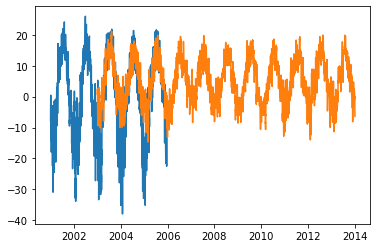

In [12]:
# Plot a few stations of temperature to make sure it exists and seems okay... 
plt.plot(dayRange, fluxnet_temp[10,:])
plt.plot(dayRange, fluxnet_temp[78,:])


/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


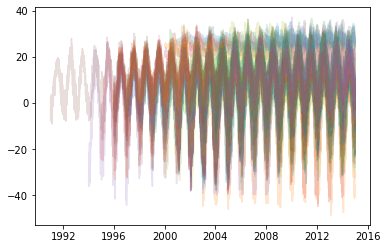

In [13]:
# Plot all the stations timeseries of temperature to see where most obs are 

for iStation in range(len(dataFiles_filter)):
    plt.plot(dayRange,fluxnet_temp[iStation,:],alpha=0.2)
    

/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


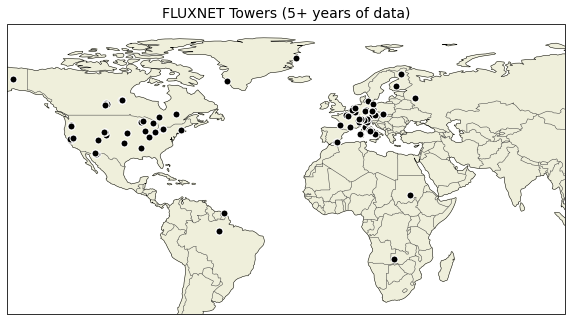

In [26]:
# ---- Maps of correlation coefficients ---- # 
# Set up figure
fig, ax1 = plt.subplots(1,1, figsize=(10, 7),subplot_kw={'projection':ccrs.PlateCarree()})

# Set limits of plot
ax1.set_extent([-150, 100, -40, 90], crs=ccrs.PlateCarree())
# Add coastlines 
ax1.coastlines(linewidth=0.5,edgecolor='0.25')
ax1.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
ax1.add_feature(cfeature.LAND)
ax1.set_title('FLUXNET Towers (5+ years of data)', fontsize=14)

p = ax1.plot(np.asarray(lon_fluxnet), np.asarray(lat_fluxnet),'ko',transform=ccrs.PlateCarree(),
            markeredgecolor='w',markersize=7)



In [15]:
np.shape(lat_fluxnet)

(116,)

## 2. Read in model data 

Note: Created a netCDF file containing model data at gridcells that line up with the FLUXNET stations, so just read that in.

In [11]:
dataPath = '/Users/mdfowler/Documents/Analysis/CLUBB_initial/data/processed_dailyCESMatFLUXNETstations.nc'
modelDS  = xr.open_dataset(dataPath, decode_times=True)


In [12]:
# Set up directories 
dataDir     = '/Users/mdfowler/Documents/Analysis/CLUBB_initial/data/daily/'
nameStart   = 'f.e20.FHIST.f09_f09.cesm2_1.001.cam.h1.'
nameEnd_UV  = '_sfcLevs-dailyUV.nc'
nameEnd_FLX = '_dailySfcFluxes.nc'
nameEnd_TS  = '_TSprecip.nc'

decadeList  = ['2000-14']


/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [14]:
# # Read in data by decade 
# for iDec in range(len(decadeList)): 
    
#     # Open datasets for each decade 
# #     fileName       = dataDir+nameStart+decadeList[iDec]+nameEnd
# #     dataDF         = xr.open_dataset(fileName, decode_times=True)
# #     dataDF['time'] = dataDF.indexes['time'].to_datetimeindex() # Convert from cf time (non-standard calendar) to datetime

#     UVfile         = dataDir+nameStart+decadeList[iDec]+nameEnd_UV 
#     windDF         = xr.open_dataset(UVfile, decode_times=True)
#     windDF['time'] = windDF.indexes['time'].to_datetimeindex()
    
#     FLXfile       = dataDir+nameStart+decadeList[iDec]+nameEnd_FLX
#     flxDF         = xr.open_dataset(FLXfile, decode_times=True)
#     flxDF['time'] = flxDF.indexes['time'].to_datetimeindex()
    
#     TSfile        = dataDir+nameStart+decadeList[iDec]+nameEnd_TS
#     tsDF          = xr.open_dataset(TSfile, decode_times=True)
#     tsDF['time']  = tsDF.indexes['time'].to_datetimeindex()

#     # Create *giant* datasets that span the full period of the simulations
#     if iDec==0:
# #         fullDF   = dataDF
#         fullUV   = windDF
#         fullFLX  = flxDF
#         fullTS   = tsDF
#     else:
# #         fullDF   = xr.concat([fullDF, dataDF], dim="time")
#         fullUV   = xr.concat([fullUV, windDF], dim="time")
#         fullFLX  = xr.concat([fullFLX, flxDF], dim="time")
#         fullTS   = xr.concat([fullTS,   tsDF], dim="time")
        
#     windDF.close()
#     flxDF.close()
#     tsDF.close()
        
#     print('Done with decade ', decadeList[iDec], ' ... ')
    

<ipython-input-14-e10f59f11f62>:11: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  windDF['time'] = windDF.indexes['time'].to_datetimeindex()
<ipython-input-14-e10f59f11f62>:15: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  flxDF['time'] = flxDF.indexes['time'].to_datetimeindex()


Done with decade  2000-14  ... 


<ipython-input-14-e10f59f11f62>:19: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  tsDF['time']  = tsDF.indexes['time'].to_datetimeindex()


In [15]:
# print('Units on precip: ', tsDF.PRECT.units)
# print('Units on TS:     ', tsDF.TS.units)
# print('Units on fluxes: ', flxDF.SHFLX.units)
# print('Units on wind:   ', windDF.U.units)

Units on precip:  m/s
Units on TS:      K
Units on fluxes:  W/m2
Units on wind:    m/s


In [23]:
# ## Load in pickle file containing near-surface temprature gradient (TBOT-TS) [K]
# gradFile  = dataDir+nameStart+'1990-2014_gradT_daily.p'
# with open( gradFile, "rb" ) as pic: 
#     delT = pickle.load(pic)
    

In [31]:
# np.shape(delT)

(9111, 192, 288)

In [14]:
# # To be able to easily access years, months, days - use Pandas 
# dates = pd.DatetimeIndex(fullFLX['time'].values) 

# # # Let's set the monthly averages to be roughly mid-month
# # #   This way, the average for January has a month of 1 instead of being the first day of February 
# # midTime = dates - timedelta(days=15)       


In [15]:
# # Read into individual arrays for easy access
# SHFLX = fullFLX.SHFLX.values
# LHFLX = fullFLX.LHFLX.values
# TS    = fullTS.TS.values 
# PRECT = fullTS.PRECT.values
# U     = fullUV.U.values              # Zonal wind (m/s)
# V     = fullUV.V.values              # Meridional wind (m/s)


In [16]:
# # # Flip along vertical (level) axis, so that index 0 is surface 
# U   = np.flip(U,   axis=1)
# V   = np.flip(V,   axis=1)

# # # Save levels themselves to arrays and flip them too (avoids confusion later, hopefully)
# lev_middle    = np.flip(fullUV.lev.values)
# print(lev_middle)

[992.55609512 976.32540739]


In [17]:
# # Now get surface wind magnitude and combine variances 
# windSpd = np.sqrt(U**2 + V**2)

# # Select near surface speed and variance 
# sfcWindSpd = windSpd[:,0,:,:]


In [18]:
# # Define lat and lon for model
# lat = fullFLX.lat.values
# lon = fullFLX.lon.values

In [19]:
# # Remove some of the larger arrays from memory now that we don't need them 
# del U 
# del V 


### 2.1 Get model data at gridcells containing towers 

In [23]:
# # Empty arrays to save data into 
# model_spd    = np.full([len(dataFiles_filter), len(dates)], np.nan)
# model_SH     = np.full([len(dataFiles_filter), len(dates)], np.nan)
# model_LH     = np.full([len(dataFiles_filter), len(dates)], np.nan)
# model_TS     = np.full([len(dataFiles_filter), len(dates)], np.nan)
# model_precip = np.full([len(dataFiles_filter), len(dates)], np.nan)

# # Consider each station individually 
# for iStation in range(len(dataFiles_filter)):
    
#     # Get model gridcells that match fluxnet site 
#     iLat        = np.where( (lat>=(lat_fluxnet[iStation]-0.4712)) & 
#                             (lat<=(lat_fluxnet[iStation]+0.4712)) )[0]
#      # Convert longitude of point into 0-360 range 
#     lonSel_flux = (lon_fluxnet[iStation] + 360) % 360                
#     iLon        = np.where( (lon>=(lonSel_flux-0.625)) & 
#                             (lon<=(lonSel_flux+0.625)) )[0]
    
#     # Pull out model variables for each station's gridcell 
#     model_spd[iStation,:]     = np.squeeze(sfcWindSpd[:,iLat,iLon])
#     model_SH[iStation,:]      = np.squeeze(SHFLX[:,iLat,iLon])
#     model_LH[iStation,:]      = np.squeeze(LHFLX[:,iLat,iLon])
#     model_TS[iStation,:]      = np.squeeze(TS[:,iLat,iLon])
#     model_precip[iStation,:]  = np.squeeze(PRECT[:,iLat,iLon])
    

In [29]:
# # Merge above into dataset and save out to netCDF 
# model_DS = xr.Dataset({
#              'model_spd' : xr.DataArray(
#                              data   = model_spd, 
#                              dims   = ['station','time'],
#                              coords = {'station': stationID, 
#                                        'time':dates},
#                              attrs  = {'Longname': 'Surface wind speed',
#                                        'Units': 'm/s'} 
#                          ),
#              'model_SH' : xr.DataArray(
#                              data   = model_SH, 
#                              dims   = ['station','time'],
#                              coords = {'station': stationID, 
#                                        'time':dates},
#                              attrs  = {'Longname': 'Sensible heat flux',
#                                        'Units': 'W/m2'} 
#                          ),
#               'model_TS' : xr.DataArray(
#                              data   = model_TS, 
#                              dims   = ['station','time'],
#                              coords = {'station': stationID, 
#                                        'time':dates},
#                              attrs  = {'Longname': 'Surface temperature (TS)',
#                                        'Units': 'K'} 
#                          ),
#              'model_LH' : xr.DataArray(
#                              data   = model_LH, 
#                              dims   = ['station','time'],
#                              coords = {'station': stationID, 
#                                        'time':dates},
#                              attrs  = {'Longname': 'Latent heat flux',
#                                        'Units': 'W/m2'} 
#                          ),
                
#              'model_precip' : xr.DataArray(
#                              data   = model_precip, 
#                              dims   = ['station','time'],
#                              coords = {'station': stationID, 
#                                        'time':dates},
#                              attrs  = {'Longname': 'Total Precipitation (PRECT)',
#                                        'Units': 'm/s'} 
#                          ),           
# })


In [31]:
# # Save to netCDF
# model_DS.to_netcdf(path='/Users/mdfowler/Documents/Analysis/CLUBB_initial/data/processed_dailyCESMatFLUXNETstations.nc',
#                    mode='w')

### 2.2 Pull out stability information too 

In [12]:
# Year strings to create file names 
yearSel = np.arange(2000,2010)

# Ten years of data and 7 levels (closest to surface) for Ri were computed 
Ri = np.full([365*len(yearSel), 7, 192, 288], np.nan)   # Hard coding in lat/lon dims as well for ease. NOT best practice
dates_Ri = np.empty(365*len(yearSel), dtype='datetime64[s]')
yrCount  = 0 

for iYr in range(len(yearSel)):
    Ri_File = dataDir+'GradientRichardsonNumber_'+str(yearSel[iYr])+'.nc'
    
    with xr.open_dataset(Ri_File, decode_times=False) as RiTemp: 
        # Number of days saved in file 
        RiTemp = xr.decode_cf(RiTemp)  # decode to datetime object
        numDays = len(RiTemp.time.values)
        
        # Last year of calculation includes some of the next year; cut it off  
        if yearSel[iYr]==yearSel[-1]:
            dateStop_str = str(yearSel[iYr])+'-12-31'
            iStop = np.where(RiTemp.time.values==np.datetime64(dateStop_str))[0]
            
            Ri[yrCount::,:,:,:] = RiTemp.__xarray_dataarray_variable__.values[0:iStop[0],:,:,:]
            dates_Ri[yrCount::] = RiTemp.time.values[0:iStop[0]]
            yrCount = yrCount+iStop
            
        #First year of calculation starts on Jan 26th; leave blank spaces up front 
        #   Note that for dates_Ri, these blanks will be set as 1970. Just ignore. 
        elif str(yearSel[iYr])=='2000':
            Ri[26:yrCount+26+numDays,:,:,:] = RiTemp.__xarray_dataarray_variable__.values
            dates_Ri[26:yrCount+26+numDays] = RiTemp.time.values
            yrCount = yrCount+26+numDays
    
        else:    
            Ri[yrCount:yrCount+numDays,:,:,:] = RiTemp.__xarray_dataarray_variable__.values
            dates_Ri[yrCount:yrCount+numDays] = RiTemp.time.values
            yrCount = yrCount+numDays
        
        if iYr==0:
            lev_Ri = RiTemp.lev.values 
            lon_Ri = RiTemp.lon.values
            lat_Ri = RiTemp.lat.values
        

In [19]:
# Empty arrays to save data into 
model_Ri    = np.full([len(dataFiles_filter), len(dates_Ri), len(lev_Ri)], np.nan)

# Consider each station individually 
for iStation in range(len(dataFiles_filter)):
    
    # Get model gridcells that match fluxnet site 
    iLat        = np.where( (lat_Ri>=(lat_fluxnet[iStation]-0.4712)) & 
                            (lat_Ri<=(lat_fluxnet[iStation]+0.4712)) )[0]
     # Convert longitude of point into 0-360 range 
    lonSel_flux = (lon_fluxnet[iStation] + 360) % 360                
    iLon        = np.where( (lon_Ri>=(lonSel_flux-0.625)) & 
                            (lon_Ri<=(lonSel_flux+0.625)) )[0]
    
    # Pull out model variables for each station's gridcell 
    model_Ri[iStation,:,:]     = np.squeeze(Ri[:,:,iLat,iLon])


In [20]:
np.shape(model_Ri)

(116, 3650, 7)

<ipython-input-113-62ac9ff8d7d3>:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(ds.lon,ds.lat, np.squeeze(ds.__xarray_dataarray_variable__.values[200,-1,:,:]),


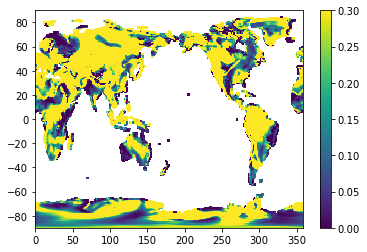

In [113]:
# Quick test to make sure Ri works 
yearSel='2000'
Ri_File = dataDir+'GradientRichardsonNumber_'+yearSel+'.nc'
ds = xr.open_dataset(Ri_File,decode_times=True)
plt.pcolormesh(ds.lon,ds.lat, np.squeeze(ds.__xarray_dataarray_variable__.values[200,-1,:,:]),
              vmax=0.3,vmin=0)
plt.colorbar()

In [17]:
ds.time

<xarray.DataArray 'time' (time: 360)>
array(['2007-01-21T00:00:00.000000000', '2007-01-22T00:00:00.000000000',
       '2007-01-23T00:00:00.000000000', ..., '2008-01-13T00:00:00.000000000',
       '2008-01-14T00:00:00.000000000', '2008-01-15T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2007-01-21 2007-01-22 ... 2008-01-15

## 3. Start looking at timeseries 

In [14]:
# Selection station of interest: 
#  Valid choices are in range 0-115
stationChoice = 2


In [15]:
# Get dates of observations at that station 
iStart = pd.DatetimeIndex(startTime_fluxnet_sel)[stationChoice] 
iEnd   = pd.DatetimeIndex(endTime_fluxnet_sel)[stationChoice]
print('Obs start on: ', iStart )
print('Obs end on:   ', iEnd   )


# Match model data to that date range and pull out selected station
modelTime = pd.DatetimeIndex(modelDS['time'].values) 
iTimes    = np.where((modelTime>=iStart) & (modelTime<=iEnd) )[0]

modelDS_station = modelDS.isel(time=iTimes,station=stationChoice)


Obs start on:  1998-01-01 00:00:00
Obs end on:    2014-12-31 00:00:00


In [16]:
# Get units in observations to match what's in model...
fluxnet_temp_K    = fluxnet_temp + 273.15            # Convert from degC to K 
fluxnet_precip_ms = (fluxnet_precip/86400.0)/1000.0  # Convert from mm/day to m/s 


In [87]:
# Let's print out a few summary statistics for the selected station first...
# --------------------------------------------------------------------------

# Modeled correlations and biases 
print('Station: %8s' % stationID[stationChoice])
print('-----------------------------------------------------')
print(' Annual mean bias in SHFLX:  ') 
print(' Annual mean bias in SH+LH:  ')
print(' Annual mean bias in TS:     ')
print(' Annual mean bias in precip: ')
print()
print('                   JJA-mean Model         Bias from')
print('                    correlations        observations')
print('                 -----------------      -------------')
print(' spd-vs-shf    ')
print(' spd-vs-shf+lhf')
print(' spd-vs-ts     ')


Station:   US-NR1
-----------------------------------------------------
 Annual mean bias in SHFLX:  
 Annual mean bias in SH+LH:  
 Annual mean bias in TS:     
 Annual mean bias in precip: 

                   JJA-mean Model         Bias from
                    correlations        observations
                 -----------------      -------------
 spd-vs-shf    
 spd-vs-shf+lhf
 spd-vs-ts     


### Plots

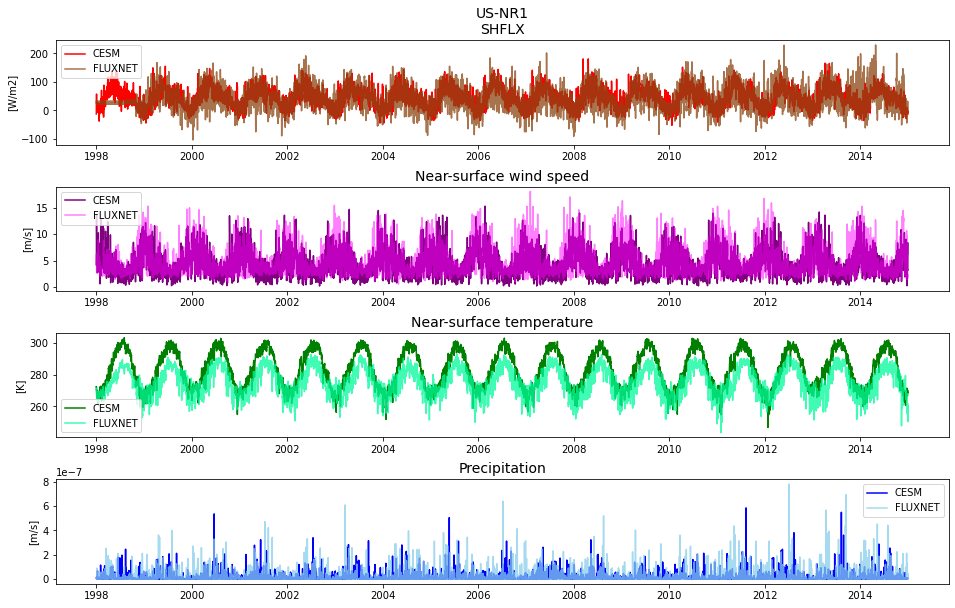

In [83]:
fig, axs = plt.subplots(4,1, figsize=(16, 10))
#Put axs handles in array, axs 
axs = axs.ravel()
#Adjust space between subplots 
fig.subplots_adjust(hspace = 0.4,wspace = 0.25)


# ------------------------------------
#   Panel 1: SHFLX 
axs[0].plot(modelDS_station.time.values, modelDS_station.model_SH.values,'r-')
axs[0].plot(dayRange, fluxnet_SH[stationChoice,:],'saddlebrown',alpha=0.75)
axs[0].legend(['CESM','FLUXNET'])
axs[0].set_title(stationID[stationChoice]+'\nSHFLX', fontsize=14)
axs[0].set_ylabel('[W/m2]')

# ------------------------------------
#  Panel 2: Wind speed 
axs[1].plot(modelDS_station.time.values, modelDS_station.model_spd.values,'purple')
axs[1].plot(dayRange, fluxnet_spd[stationChoice,:],'magenta',alpha=0.5)
axs[1].legend(['CESM','FLUXNET'])
axs[1].set_title('Near-surface wind speed', fontsize=14)
axs[1].set_ylabel('[m/s]')

# ------------------------------------
#  Panel 3: Surface temperature 
axs[2].plot(modelDS_station.time.values, modelDS_station.model_TS.values,'green')
axs[2].plot(dayRange, fluxnet_temp_K[stationChoice,:],'mediumspringgreen',alpha=0.75)
axs[2].legend(['CESM','FLUXNET'])
axs[2].set_title('Near-surface temperature', fontsize=14)
axs[2].set_ylabel('[K]')

# ------------------------------------
#  Panel 4: Precipitation
axs[3].plot(modelDS_station.time.values, modelDS_station.model_precip.values,'blue')
axs[3].plot(dayRange, fluxnet_precip_ms[stationChoice,:],'skyblue',alpha=0.75)
axs[3].legend(['CESM','FLUXNET'])
axs[3].set_title('Precipitation', fontsize=14)
axs[3].set_ylabel('[m/s]')


plt.show()

## 4. Assess by large scale things 

First step is to assess via precipitation in model and obs (classify both seperately) and assess biases accordingly. 
* On the most basic level - is it raining (>0 m/s)? 
* On a slightly more nuanced approach - how much rain in a day? (e.g., 0-1 mm/day, 1-5 mm/day, 5-10 mm/day, etc). 
* On a more detailed approach (which likely requires hourly data, really) - what happens to biases on a wet/dry day following a wet/dry day? (see Burns et al., Fig. 1) 

In [17]:
# Model rainfall is in m/s -- convert to mm/day
model_precip = modelDS.model_precip.values * 8.64e7


Really basic first - is it raining or not? 

In [18]:
''' 
Function to figure out mean fluxes by month 
conditioned on whether or not rain is occuring
(binary situation - yes or no).

Inputs: 
   time:   np.datetime64 array of dates 
   precip: np array of precipitation (mm/day)
   var:    Variable of interest to get monthly 
           means for based on rain presence.
           
*NOTE* In this context, I'm assuming that though
       time is one dimension, precip and var will 
       be two dimensional: [location, time].
       This *could* probably be generalized, but 
       not quite worth the time right now. 
'''

def MonthlyFluxes_byRainBinary(time,precip,var):
    # Check which dimension corresponds to time
    nTimes  = len(time)
    nShape  = np.asarray(np.shape(var))
    timeDim = np.where(nShape==nTimes)[0]
    if timeDim!=1: 
        print('** TIME DIMENSION NOT IN EXPECTED POSITION **')
        
    # Convert np.datetime64 time array to pandas (a little easier to work with)
    dates = pd.DatetimeIndex(time)
    
    # Define array of months to identify
    months=np.arange(1,13)
    
    # Define empty arrays to return 
    monthlyVarMean_rain = np.full([nShape[0], len(months)], np.nan)
    monthlyVarMean_dry  = np.full([nShape[0], len(months)], np.nan)
    
    for iMonth in range(len(months)):
        # Select all days in this month 
        selMonth  = np.where(dates.month==months[iMonth])[0]
        varMonth  = var[:,selMonth]
        precMonth = precip[:,selMonth]
        
        # Find days that rain vs. don't 
        rainDay = np.copy(precMonth)
        rainDay[precMonth>0]  = 1
        rainDay[precMonth<=0] = np.nan
        
        dryDay = np.copy(precMonth)
        dryDay[precMonth>0]  = np.nan
        dryDay[precMonth==0] = 1
        
        # Get mean variable on dry and wet days 
        monthlyVarMean_rain[:,iMonth] = np.nanmean(varMonth*rainDay, axis=1)
        monthlyVarMean_dry[:,iMonth]  = np.nanmean(varMonth*dryDay,  axis=1)

    return(monthlyVarMean_rain,monthlyVarMean_dry)

In [19]:
# Get monthly break down of surface fluxes in obs/model by presence of rain 
obsEF = fluxnet_LH/(fluxnet_LH+fluxnet_SH)
monthlyObsSHmean_rain, monthlyObsSHmean_dry = MonthlyFluxes_byRainBinary(dayRange, fluxnet_precip, fluxnet_SH)
monthlyObsLHmean_rain, monthlyObsLHmean_dry = MonthlyFluxes_byRainBinary(dayRange, fluxnet_precip, fluxnet_LH)
monthlyObsEFmean_rain, monthlyObsEFmean_dry = MonthlyFluxes_byRainBinary(dayRange, fluxnet_precip, obsEF)

modEF = modelDS.model_LH.values/(modelDS.model_LH.values+modelDS.model_SH.values)
monthlyModSHmean_rain, monthlyModSHmean_dry = MonthlyFluxes_byRainBinary(modelDS.time.values, model_precip, modelDS.model_SH.values)
monthlyModLHmean_rain, monthlyModLHmean_dry = MonthlyFluxes_byRainBinary(modelDS.time.values, model_precip, modelDS.model_LH.values)
monthlyModEFmean_rain, monthlyModEFmean_dry = MonthlyFluxes_byRainBinary(modelDS.time.values, model_precip, modEF)


<ipython-input-19-e299976805fd>:2: RuntimeWarning: invalid value encountered in true_divide
  obsEF = fluxnet_LH/(fluxnet_LH+fluxnet_SH)
<ipython-input-18-d71490428798>:53: RuntimeWarning: Mean of empty slice
  monthlyVarMean_rain[:,iMonth] = np.nanmean(varMonth*rainDay, axis=1)
<ipython-input-18-d71490428798>:53: RuntimeWarning: Mean of empty slice
  monthlyVarMean_rain[:,iMonth] = np.nanmean(varMonth*rainDay, axis=1)
<ipython-input-18-d71490428798>:54: RuntimeWarning: Mean of empty slice
  monthlyVarMean_dry[:,iMonth]  = np.nanmean(varMonth*dryDay,  axis=1)
<ipython-input-18-d71490428798>:54: RuntimeWarning: Mean of empty slice
  monthlyVarMean_dry[:,iMonth]  = np.nanmean(varMonth*dryDay,  axis=1)
<ipython-input-18-d71490428798>:53: RuntimeWarning: Mean of empty slice
  monthlyVarMean_rain[:,iMonth] = np.nanmean(varMonth*rainDay, axis=1)
<ipython-input-18-d71490428798>:53: RuntimeWarning: Mean of empty slice
  monthlyVarMean_rain[:,iMonth] = np.nanmean(varMonth*rainDay, axis=1)
<ipyt

In [76]:
np.shape(monthlyObsSHmean_rain)

/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(116, 12)

/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


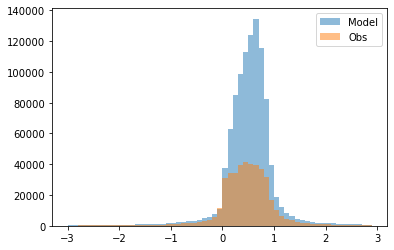

In [19]:
bins = np.arange(-3,3,0.1)
plt.hist(modEF.reshape(np.shape(modEF)[0]*np.shape(modEF)[1]),bins,alpha=0.5)
plt.hist(obsEF.reshape(np.shape(obsEF)[0]*np.shape(obsEF)[1]),bins,alpha=0.5)
plt.legend(['Model','Obs'])
plt.show()

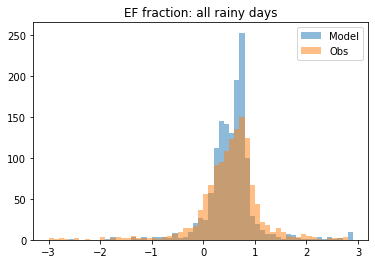

In [20]:
bins = np.arange(-3,3,0.1)
plt.hist(monthlyModEFmean_rain.reshape(np.shape(monthlyModEFmean_rain)[0]*np.shape(monthlyModEFmean_rain)[1]),bins,alpha=0.5)
plt.hist(monthlyObsEFmean_rain.reshape(np.shape(monthlyObsEFmean_rain)[0]*np.shape(monthlyObsEFmean_rain)[1]),bins,alpha=0.5)
plt.legend(['Model','Obs'])
plt.title('EF fraction: all rainy days')
plt.show()

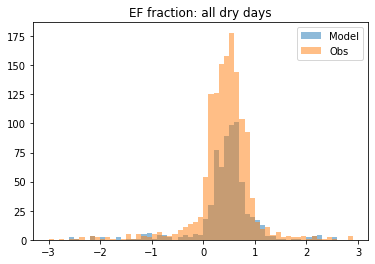

In [21]:
bins = np.arange(-3,3,0.1)
plt.hist(monthlyModEFmean_dry.reshape(np.shape(monthlyModEFmean_dry)[0]*np.shape(monthlyModEFmean_dry)[1]),bins,alpha=0.5)
plt.hist(monthlyObsEFmean_dry.reshape(np.shape(monthlyObsEFmean_dry)[0]*np.shape(monthlyObsEFmean_dry)[1]),bins,alpha=0.5)
plt.legend(['Model','Obs'])
plt.title('EF fraction: all dry days')
plt.show()

Get mean for rain/not fluxes on *all* days

In [23]:
# Get units in observations to match what's in model...
fluxnet_temp_K    = fluxnet_temp + 273.15            # Convert from degC to K 
fluxnet_precip_ms = (fluxnet_precip/86400.0)/1000.0  # Convert from mm/day to m/s 


In [20]:
# Mask for when rain occurs at all
rainMask_obs = np.copy(fluxnet_precip)
rainMask_obs[fluxnet_precip>0]    = 1
rainMask_obs[fluxnet_precip==0.0] = np.nan

dryMask_obs = np.copy(fluxnet_precip)
dryMask_obs[fluxnet_precip>0.0]  = np.nan
dryMask_obs[fluxnet_precip==0.0] = 1

rainMask_mod = np.copy(model_precip)
rainMask_mod[model_precip>0]    = 1
rainMask_mod[model_precip==0.0] = np.nan

dryMask_mod = np.copy(model_precip)
dryMask_mod[model_precip>0.0]  = np.nan
dryMask_mod[model_precip==0.0] = 1

# Get mean of model/obs variables during rainy/dry days
# ------- Obs days 
obsSH_rainDays  = np.nanmean(fluxnet_SH*rainMask_obs,axis=1)
obsSH_dryDays   = np.nanmean(fluxnet_SH*dryMask_obs, axis=1)

obsLH_rainDays  = np.nanmean(fluxnet_LH*rainMask_obs,axis=1)
obsLH_dryDays   = np.nanmean(fluxnet_LH*dryMask_obs, axis=1)

obsTS_rainDays  = np.nanmean(fluxnet_temp_K*rainMask_obs,axis=1)
obsTS_dryDays   = np.nanmean(fluxnet_temp_K*dryMask_obs, axis=1)

obsEF_rainDays  = np.nanmean((fluxnet_LH*rainMask_obs/((fluxnet_LH*rainMask_obs)+(fluxnet_SH*rainMask_obs))),axis=1)
obsEF_dryDays   = np.nanmean((fluxnet_LH*dryMask_obs/((fluxnet_LH*dryMask_obs)+(fluxnet_SH*dryMask_obs))),axis=1)


# ------- Model days 
modSH_rainDays  = np.nanmean(modelDS.model_SH.values*rainMask_mod,axis=1)
modSH_dryDays   = np.nanmean(modelDS.model_SH.values*dryMask_mod, axis=1)

modLH_rainDays  = np.nanmean(modelDS.model_LH.values*rainMask_mod,axis=1)
modLH_dryDays   = np.nanmean(modelDS.model_LH.values*dryMask_mod, axis=1)

modTS_rainDays  = np.nanmean(modelDS.model_TS.values*rainMask_mod,axis=1)
modTS_dryDays   = np.nanmean(modelDS.model_TS.values*dryMask_mod, axis=1)

modEF_rainDays  = np.nanmean((modelDS.model_LH.values*rainMask_mod/((modelDS.model_LH.values*rainMask_mod)+(modelDS.model_SH.values*rainMask_mod))),axis=1)
modEF_dryDays   = np.nanmean((modelDS.model_LH.values*dryMask_mod/((modelDS.model_LH.values*dryMask_mod)+(modelDS.model_SH.values*dryMask_mod))),axis=1)



/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-20-7d8dd5cdfda0>:29: RuntimeWarning: invalid value encountered in true_divide
  obsEF_rainDays  = np.nanmean((fluxnet_LH*rainMask_obs/((fluxnet_LH*rainMask_obs)+(fluxnet_SH*rainMask_obs))),axis=1)
<ipython-input-20-7d8dd5cdfda0>:35: RuntimeWarning: Mean of empty slice
  modSH_dryDays   = np.nanmean(modelDS.model_SH.values*dryMask_mod, axis=1)


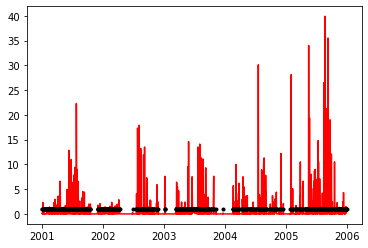

In [21]:
# Confirming most basic mask works... 
plt.plot(dayRange,fluxnet_precip[10,:],'r')
plt.plot(dayRange,rainMask_obs[10,:], 'k.')
#plt.xlim(np.datetime64('2001-12-01'),np.datetime64('2002-03-01'))
#plt.ylim(0,5)

Slightly more complex - separate days based on rain rate, first for all days and then per month (similar to above)

In [22]:
# Mask by rain bins 
#   Classification by log spaced array 
rainBins = np.logspace(0,2,10)
rainBins = np.insert(rainBins,0,0)  #Add first bin = 0

# Empty arrays to save means into for each bin/station 
obsSH_rainBins = np.full([np.shape(fluxnet_precip)[0],len(rainBins)],np.nan)
obsLH_rainBins = np.full([np.shape(fluxnet_precip)[0],len(rainBins)],np.nan)
obsTS_rainBins = np.full([np.shape(fluxnet_precip)[0],len(rainBins)],np.nan)
obsEF_rainBins = np.full([np.shape(fluxnet_precip)[0],len(rainBins)],np.nan)

modSH_rainBins = np.full([np.shape(fluxnet_precip)[0],len(rainBins)],np.nan)
modLH_rainBins = np.full([np.shape(fluxnet_precip)[0],len(rainBins)],np.nan)
modTS_rainBins = np.full([np.shape(fluxnet_precip)[0],len(rainBins)],np.nan)
modEF_rainBins = np.full([np.shape(fluxnet_precip)[0],len(rainBins)],np.nan)


for iBin in range(len(rainBins)-1):
    # ---- Fluxnet Obs part ---- 
    maskBin_obs = np.copy(fluxnet_precip)
    maskBin_obs[:,:] = np.nan
    
    maskBin_obs[(fluxnet_precip>rainBins[iBin]) & (fluxnet_precip<=rainBins[iBin+1])] = 1
    # print('Start: %.2f .... End: %.2f ' % (rainBins[iBin], rainBins[iBin+1]))
    
    obsSH_rainBins[:,iBin] = np.nanmean(fluxnet_SH*maskBin_obs,      axis=1)
    obsLH_rainBins[:,iBin] = np.nanmean(fluxnet_LH*maskBin_obs,      axis=1)
    obsTS_rainBins[:,iBin] = np.nanmean(fluxnet_temp_K*maskBin_obs,  axis=1)
    obsEF = fluxnet_LH/(fluxnet_LH+fluxnet_SH)
    obsEF_rainBins[:,iBin] = np.nanmean(obsEF*maskBin_obs,      axis=1)
    
    
    # ---- Model part ----
    maskBin_mod = np.copy(model_precip)
    maskBin_mod[:,:] = np.nan
    
    maskBin_mod[(model_precip>rainBins[iBin]) & (model_precip<=rainBins[iBin+1])] = 1
    
    modSH_rainBins[:,iBin] = np.nanmean(modelDS.model_SH.values*maskBin_mod,  axis=1)
    modLH_rainBins[:,iBin] = np.nanmean(modelDS.model_LH.values*maskBin_mod,  axis=1)
    modTS_rainBins[:,iBin] = np.nanmean(modelDS.model_TS.values*maskBin_mod,  axis=1)
    modEF = modelDS.model_LH.values/(modelDS.model_LH.values+modelDS.model_SH.values)
    modEF_rainBins[:,iBin] = np.nanmean(modEF*maskBin_mod,      axis=1)
    

/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-22-2ab56efb525a>:29: RuntimeWarning: invalid value encountered in true_divide
  obsEF = fluxnet_LH/(fluxnet_LH+fluxnet_SH)
<ipython-input-22-2ab56efb525a>:26: RuntimeWarning: Mean of empty slice
  obsSH_rainBins[:,iBin] = np.nanmean(fluxnet_SH*maskBin_obs,      axis=1)


In [23]:
''' 
Function to figure out mean fluxes by month 
conditioned on whether or not rain is occuring
(binary situation - yes or no).

Inputs: 
   time:   np.datetime64 array of dates 
   precip: np array of precipitation (mm/day)
   binEdges: np array of rainfall bin edges to use. 
   var:    Variable of interest to get monthly 
           means for based on rain presence.
           
*NOTE* In this context, I'm assuming that though
       time is one dimension, precip and var will 
       be two dimensional: [location, time].
       This *could* probably be generalized, but 
       not quite worth the time right now. 
'''

def MonthlyFluxes_byRainBins(time,precip,binEdges,var):
    # Check which dimension corresponds to time
    nTimes  = len(time)
    nShape  = np.asarray(np.shape(var))
    timeDim = np.where(nShape==nTimes)[0]
    if timeDim!=1: 
        print('** TIME DIMENSION NOT IN EXPECTED POSITION **')
        
    # Convert np.datetime64 time array to pandas (a little easier to work with)
    dates = pd.DatetimeIndex(time)
    
    # Define array of months to identify
    months=np.arange(1,13)
    
    # Define empty arrays to return 
    monthlyVarMean_rainBins = np.full([nShape[0], len(months), len(binEdges)], np.nan)
    
    for iMonth in range(len(months)):
        # Select all days in this month 
        selMonth  = np.where(dates.month==months[iMonth])[0]
        varMonth  = var[:,selMonth]
        precMonth = precip[:,selMonth]
        
        for iBin in range(len(binEdges)-1):
            # Find days in this rain bin 
            maskBin = np.copy(precMonth)
            maskBin[:,:] = np.nan
            
            maskBin[(precMonth>rainBins[iBin]) & (precMonth<=rainBins[iBin+1])] = 1
            monthlyVarMean_rainBins[:,iMonth,iBin] = np.nanmean(varMonth*maskBin,  axis=1)


    return(monthlyVarMean_rainBins)



In [24]:
# Define rain bins
rainBins = np.logspace(0,2,10)
rainBins = np.insert(rainBins,0,0)  #Add first bin = 0

# Get monthly break down of surface fluxes in obs/model by presence of rain 
obsEF = fluxnet_LH/(fluxnet_LH+fluxnet_SH)
monthlyObsSHmean_rainBins = MonthlyFluxes_byRainBins(dayRange, fluxnet_precip, rainBins, fluxnet_SH)
monthlyObsLHmean_rainBins = MonthlyFluxes_byRainBins(dayRange, fluxnet_precip, rainBins, fluxnet_LH)
monthlyObsEFmean_rainBins = MonthlyFluxes_byRainBins(dayRange, fluxnet_precip, rainBins, obsEF)

modEF = modelDS.model_LH.values/(modelDS.model_LH.values+modelDS.model_SH.values)
monthlyModSHmean_rainBins = MonthlyFluxes_byRainBins(modelDS.time.values, model_precip, rainBins, modelDS.model_SH.values)
monthlyModLHmean_rainBins = MonthlyFluxes_byRainBins(modelDS.time.values, model_precip, rainBins, modelDS.model_LH.values)
monthlyModEFmean_rainBins = MonthlyFluxes_byRainBins(modelDS.time.values, model_precip, rainBins, modEF)


<ipython-input-24-ae45f101e70d>:6: RuntimeWarning: invalid value encountered in true_divide
  obsEF = fluxnet_LH/(fluxnet_LH+fluxnet_SH)
<ipython-input-23-7d5e7eaedfce>:49: RuntimeWarning: Mean of empty slice
  monthlyVarMean_rainBins[:,iMonth,iBin] = np.nanmean(varMonth*maskBin,  axis=1)
<ipython-input-23-7d5e7eaedfce>:49: RuntimeWarning: Mean of empty slice
  monthlyVarMean_rainBins[:,iMonth,iBin] = np.nanmean(varMonth*maskBin,  axis=1)
<ipython-input-23-7d5e7eaedfce>:49: RuntimeWarning: Mean of empty slice
  monthlyVarMean_rainBins[:,iMonth,iBin] = np.nanmean(varMonth*maskBin,  axis=1)
<ipython-input-23-7d5e7eaedfce>:49: RuntimeWarning: Mean of empty slice
  monthlyVarMean_rainBins[:,iMonth,iBin] = np.nanmean(varMonth*maskBin,  axis=1)
<ipython-input-23-7d5e7eaedfce>:49: RuntimeWarning: Mean of empty slice
  monthlyVarMean_rainBins[:,iMonth,iBin] = np.nanmean(varMonth*maskBin,  axis=1)
<ipython-input-23-7d5e7eaedfce>:49: RuntimeWarning: Mean of empty slice
  monthlyVarMean_rainBins[

<ipython-input-23-7d5e7eaedfce>:49: RuntimeWarning: Mean of empty slice
  monthlyVarMean_rainBins[:,iMonth,iBin] = np.nanmean(varMonth*maskBin,  axis=1)
<ipython-input-23-7d5e7eaedfce>:49: RuntimeWarning: Mean of empty slice
  monthlyVarMean_rainBins[:,iMonth,iBin] = np.nanmean(varMonth*maskBin,  axis=1)
<ipython-input-23-7d5e7eaedfce>:49: RuntimeWarning: Mean of empty slice
  monthlyVarMean_rainBins[:,iMonth,iBin] = np.nanmean(varMonth*maskBin,  axis=1)
<ipython-input-23-7d5e7eaedfce>:49: RuntimeWarning: Mean of empty slice
  monthlyVarMean_rainBins[:,iMonth,iBin] = np.nanmean(varMonth*maskBin,  axis=1)
<ipython-input-23-7d5e7eaedfce>:49: RuntimeWarning: Mean of empty slice
  monthlyVarMean_rainBins[:,iMonth,iBin] = np.nanmean(varMonth*maskBin,  axis=1)
<ipython-input-23-7d5e7eaedfce>:49: RuntimeWarning: Mean of empty slice
  monthlyVarMean_rainBins[:,iMonth,iBin] = np.nanmean(varMonth*maskBin,  axis=1)
<ipython-input-23-7d5e7eaedfce>:49: RuntimeWarning: Mean of empty slice
  monthlyV

**Still to do:**<br>
Last level of complexity - isolate based on wD/wW/dW/dD days, as in Burns et al. 

**Calculate biases and print summary tables**

In [25]:
# What are biases in general? 
#  Considering bias = model - obs 
#  Computing straight bias as well as absolute bias...

# ----- Biases on days that rain vs. don't -----
biasSH_rainDays    = np.nanmean(    modSH_rainDays - obsSH_rainDays)
absBiasSH_rainDays = np.nanmean(abs(modSH_rainDays - obsSH_rainDays))
biasSH_dryDays     = np.nanmean(    modSH_dryDays  - obsSH_dryDays)
absBiasSH_dryDays  = np.nanmean(abs(modSH_dryDays  - obsSH_dryDays))

biasLH_rainDays    = np.nanmean(    modLH_rainDays - obsLH_rainDays)
absBiasLH_rainDays = np.nanmean(abs(modLH_rainDays - obsLH_rainDays))
biasLH_dryDays     = np.nanmean(    modLH_dryDays  - obsLH_dryDays)
absBiasLH_dryDays  = np.nanmean(abs(modLH_dryDays  - obsLH_dryDays))

biasTS_rainDays    = np.nanmean(    modTS_rainDays - obsTS_rainDays)
absBiasTS_rainDays = np.nanmean(abs(modTS_rainDays - obsTS_rainDays))
biasTS_dryDays     = np.nanmean(    modTS_dryDays  - obsTS_dryDays)
absBiasTS_dryDays  = np.nanmean(abs(modTS_dryDays  - obsTS_dryDays))

biasEF_rainDays    = np.nanmean(    modEF_rainDays - obsEF_rainDays)
absBiasEF_rainDays = np.nanmean(abs(modEF_rainDays - obsEF_rainDays))
biasEF_dryDays     = np.nanmean(    modEF_dryDays  - obsEF_dryDays)
absBiasEF_dryDays  = np.nanmean(abs(modEF_dryDays  - obsEF_dryDays))


/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [26]:
print('---------- Flux biases at FLUXNET stations: all months ---------- ')
print('                Mean bias     Mean absolute bias  nStations')
print('                ---------     ------------------  ---------')
print('SH (rain days): %7.2f %17.2f %15i' % (biasSH_rainDays, absBiasSH_rainDays, len(np.where(np.isfinite(obsSH_rainDays==True))[0])) )
print('SH (dry  days): %7.2f %17.2f %15i' % (biasSH_dryDays,  absBiasSH_dryDays,  len(np.where(np.isfinite(obsSH_dryDays==True))[0])) )
print('--------------')
print('LH (rain days): %7.2f %17.2f %15i' % (biasLH_rainDays, absBiasLH_rainDays, len(np.where(np.isfinite(obsLH_rainDays==True))[0])) )
print('LH (dry  days): %7.2f %17.2f %15i' % (biasLH_dryDays,  absBiasLH_dryDays,  len(np.where(np.isfinite(obsLH_dryDays==True))[0])) )
print('--------------')
print('EF (rain days): %7.2f %17.2f %15i' % (biasEF_rainDays, absBiasEF_rainDays, len(np.where(np.isfinite(obsEF_rainDays==True))[0])) )
print('EF (dry  days): %7.2f %17.2f %15i' % (biasEF_dryDays,  absBiasEF_dryDays,  len(np.where(np.isfinite(obsEF_dryDays==True))[0])) )



---------- Flux biases at FLUXNET stations: all months ---------- 
                Mean bias     Mean absolute bias  nStations
                ---------     ------------------  ---------
SH (rain days):   15.76             17.60             116
SH (dry  days):  -10.22             17.28             116
--------------
LH (rain days):    6.74             14.21             116
LH (dry  days):   -4.61             16.97             116
--------------
EF (rain days):   -0.05              0.91             116
EF (dry  days):   -0.32              0.97             116


In [27]:
# Biases in binary rain classification, this time by month  
#  Considering bias = model - obs 
#  Computing straight bias as well as absolute bias...

# ----- Biases on days that rain vs. don't -----
biasSH_rainDaysMonthly    = np.nanmean(   (monthlyModSHmean_rain - monthlyObsSHmean_rain), axis=0)
absBiasSH_rainDaysMonthly = np.nanmean(abs(monthlyModSHmean_rain - monthlyObsSHmean_rain), axis=0)
biasSH_dryDaysMonthly     = np.nanmean(   (monthlyModSHmean_dry  - monthlyObsSHmean_dry),  axis=0)
absBiasSH_dryDaysMonthly  = np.nanmean(abs(monthlyModSHmean_dry  - monthlyObsSHmean_dry),  axis=0)

biasLH_rainDaysMonthly    = np.nanmean(   (monthlyModLHmean_rain - monthlyObsLHmean_rain), axis=0)
absBiasLH_rainDaysMonthly = np.nanmean(abs(monthlyModLHmean_rain - monthlyObsLHmean_rain), axis=0)
biasLH_dryDaysMonthly     = np.nanmean(   (monthlyModLHmean_dry  - monthlyObsLHmean_dry),  axis=0)
absBiasLH_dryDaysMonthly  = np.nanmean(abs(monthlyModLHmean_dry  - monthlyObsLHmean_dry),  axis=0)

biasEF_rainDaysMonthly    = np.nanmean(   (monthlyModEFmean_rain - monthlyObsEFmean_rain), axis=0)
absBiasEF_rainDaysMonthly = np.nanmean(abs(monthlyModEFmean_rain - monthlyObsEFmean_rain), axis=0)
biasEF_dryDaysMonthly     = np.nanmean(   (monthlyModEFmean_dry  - monthlyObsEFmean_dry),  axis=0)
absBiasEF_dryDaysMonthly  = np.nanmean(abs(monthlyModEFmean_dry  - monthlyObsEFmean_dry),  axis=0)


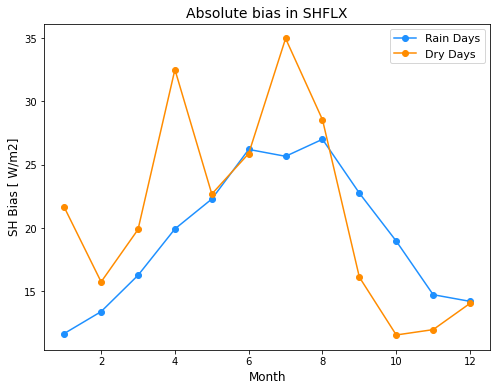

In [28]:
fig, ax1 = plt.subplots(1,1, figsize=(8, 6))

ax1.plot(np.arange(1,13), absBiasSH_rainDaysMonthly, 'o-', color='dodgerblue', label='Rain Days')
ax1.plot(np.arange(1,13), absBiasSH_dryDaysMonthly, 'o-',  color='darkorange', label='Dry Days')
ax1.set_title('Absolute bias in SHFLX', fontsize=14)
ax1.set_ylabel('SH Bias [ W/m2]',fontsize=12)
ax1.set_xlabel('Month',fontsize=12)
ax1.legend(fontsize=11)



/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


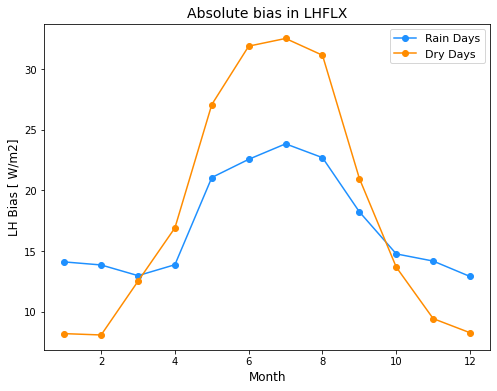

In [29]:
fig, ax1 = plt.subplots(1,1, figsize=(8, 6))

ax1.plot(np.arange(1,13), absBiasLH_rainDaysMonthly, 'o-', color='dodgerblue', label='Rain Days')
ax1.plot(np.arange(1,13), absBiasLH_dryDaysMonthly, 'o-',  color='darkorange', label='Dry Days')
ax1.set_title('Absolute bias in LHFLX', fontsize=14)
ax1.set_ylabel('LH Bias [ W/m2]',fontsize=12)
ax1.set_xlabel('Month',fontsize=12)
ax1.legend(fontsize=11)


/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


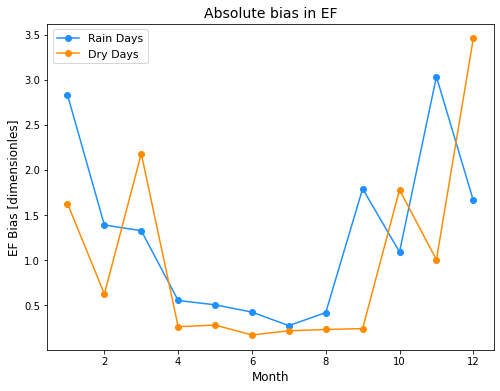

In [98]:
fig, ax1 = plt.subplots(1,1, figsize=(8, 6))

ax1.plot(np.arange(1,13), absBiasEF_rainDaysMonthly, 'o-', color='dodgerblue', label='Rain Days')
ax1.plot(np.arange(1,13), absBiasEF_dryDaysMonthly, 'o-',  color='darkorange', label='Dry Days')
ax1.set_title('Absolute bias in EF', fontsize=14)
ax1.set_ylabel('EF Bias [dimensionles]',fontsize=12)
ax1.set_xlabel('Month',fontsize=12)
ax1.legend(fontsize=11)



/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


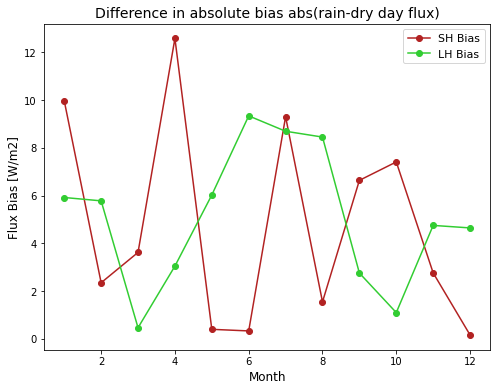

In [31]:
fig, ax1 = plt.subplots(1,1, figsize=(8, 6))

ax1.plot(np.arange(1,13), np.abs(absBiasSH_rainDaysMonthly-absBiasSH_dryDaysMonthly), 'o-', color='firebrick', label='SH Bias')
ax1.plot(np.arange(1,13), np.abs(absBiasLH_rainDaysMonthly-absBiasLH_dryDaysMonthly), 'o-', color='limegreen', label='LH Bias')
#ax1.plot(np.arange(1,13), absBiasEF_rainDaysMonthly-absBiasEF_dryDaysMonthly, 'o-', color='mediumorchid', label='EF Bias')

ax1.set_title('Difference in absolute bias abs(rain-dry day flux)', fontsize=14)
ax1.set_ylabel('Flux Bias [W/m2]',fontsize=12)
ax1.set_xlabel('Month',fontsize=12)
ax1.legend(fontsize=11)


/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


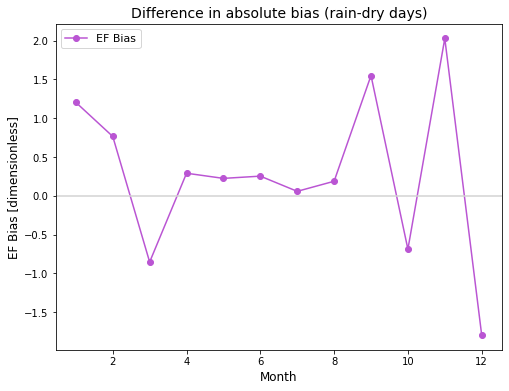

In [106]:
fig, ax1 = plt.subplots(1,1, figsize=(8, 6))

ax1.plot(np.arange(1,13), absBiasEF_rainDaysMonthly-absBiasEF_dryDaysMonthly, 'o-', color='mediumorchid', label='EF Bias')

ax1.set_title('Difference in absolute bias (rain-dry days)', fontsize=14)
ax1.set_ylabel('EF Bias [dimensionless]',fontsize=12)
ax1.set_xlabel('Month',fontsize=12)
ax1.legend(fontsize=11)

ax1.axhline(0,color='lightgrey')


In [70]:
absBiasSH_rainDays

17.596276918077113

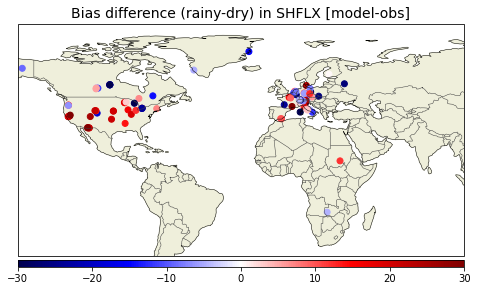

In [74]:
# ---- Difference in bias on rain-dry days ---- # 

absBiasSH_rainDays = abs(modSH_rainDays - obsSH_rainDays)
absBiasSH_dryDays  = abs(modSH_dryDays  - obsSH_dryDays)


# Set up figure
fig, ax1 = plt.subplots(1,1, figsize=(8, 5),subplot_kw={'projection':ccrs.PlateCarree()})

# Set limits of plot
ax1.set_extent([-150, 100, -40, 90], crs=ccrs.PlateCarree())

# Add coastlines 
ax1.coastlines(linewidth=0.5,edgecolor='0.25')
ax1.add_feature(cfeature.LAND)
ax1.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
ax1.set_title('Bias difference (rainy-dry) in SHFLX [model-obs]', fontsize=14)

p = ax1.scatter(lon_fluxnet, lat_fluxnet, c=(absBiasSH_rainDays-absBiasSH_dryDays) ,transform=ccrs.PlateCarree(),
               cmap='seismic',vmin=-30,vmax=30,edgecolors='face')

ax_position = ax1.get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.03, ax_position.width, 0.02])
cbar        = plt.colorbar(p, orientation='horizontal', cax=cbar_ax)





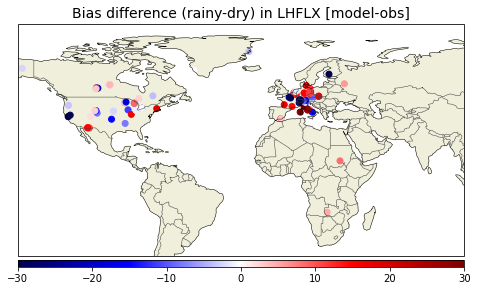

In [75]:
# ---- Difference in bias on rain-dry days ---- # 

absBiasLH_rainDays = abs(modLH_rainDays - obsLH_rainDays)
absBiasLH_dryDays  = abs(modLH_dryDays  - obsLH_dryDays)


# Set up figure
fig, ax1 = plt.subplots(1,1, figsize=(8, 5),subplot_kw={'projection':ccrs.PlateCarree()})

# Set limits of plot
ax1.set_extent([-150, 100, -40, 90], crs=ccrs.PlateCarree())

# Add coastlines 
ax1.coastlines(linewidth=0.5,edgecolor='0.25')
ax1.add_feature(cfeature.LAND)
ax1.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
ax1.set_title('Bias difference (rainy-dry) in LHFLX [model-obs]', fontsize=14)

p = ax1.scatter(lon_fluxnet, lat_fluxnet, c=(absBiasLH_rainDays-absBiasLH_dryDays) ,transform=ccrs.PlateCarree(),
               cmap='seismic',vmin=-30,vmax=30,edgecolors='face')

ax_position = ax1.get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.03, ax_position.width, 0.02])
cbar        = plt.colorbar(p, orientation='horizontal', cax=cbar_ax)






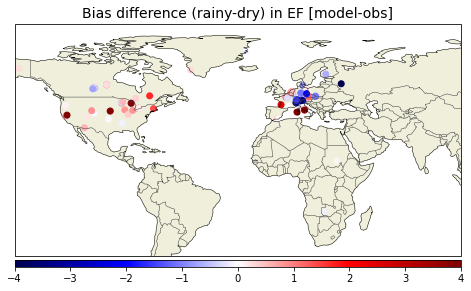

In [79]:
# ---- Difference in bias on rain-dry days ---- # 

absBiasEF_rainDays = abs(modEF_rainDays - obsEF_rainDays)
absBiasEF_dryDays  = abs(modEF_dryDays  - obsEF_dryDays)


# Set up figure
fig, ax1 = plt.subplots(1,1, figsize=(8, 5),subplot_kw={'projection':ccrs.PlateCarree()})

# Set limits of plot
ax1.set_extent([-150, 100, -40, 90], crs=ccrs.PlateCarree())

# Add coastlines 
ax1.coastlines(linewidth=0.5,edgecolor='0.25')
ax1.add_feature(cfeature.LAND)
ax1.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
ax1.set_title('Bias difference (rainy-dry) in EF [model-obs]', fontsize=14)

p = ax1.scatter(lon_fluxnet, lat_fluxnet, c=(absBiasEF_rainDays-absBiasEF_dryDays) ,transform=ccrs.PlateCarree(),
               cmap='seismic',vmin=-4,vmax=4,edgecolors='face')

ax_position = ax1.get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.03, ax_position.width, 0.02])
cbar        = plt.colorbar(p, orientation='horizontal', cax=cbar_ax)







In [331]:
monthLabels=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

print('---------- SH Flux biases at FLUXNET stations: by month ---------- ')
print('             Mean bias     Mean absolute bias ')
print('             ---------     ------------------ ')
for iMon in range(12):
    print('[rain] %2s %8.2f %15.2f' % (monthLabels[iMon], biasSH_rainDaysMonthly[iMon], absBiasSH_rainDaysMonthly[iMon]))
    print('[dry]  %13.2f %14.2f' % (biasSH_dryDaysMonthly[iMon], absBiasSH_dryDaysMonthly[iMon]))
    print()



---------- SH Flux biases at FLUXNET stations: by month ---------- 
             Mean bias     Mean absolute bias 
             ---------     ------------------ 
[rain] Jan     4.34           11.77
[dry]         -18.79          19.79

[rain] Feb     4.39           13.32
[dry]         -11.36          14.61

[rain] Mar     6.60           16.33
[dry]         -11.89          19.83

[rain] Apr    15.11           20.22
[dry]         -11.55          28.26

[rain] May    18.03           22.66
[dry]           4.59          22.02

[rain] Jun    18.91           26.32
[dry]           2.18          25.47

[rain] Jul    20.64           26.76
[dry]           9.48          37.75

[rain] Aug    23.28           27.70
[dry]           2.19          31.81

[rain] Sep    21.99           23.36
[dry]           2.96          15.65

[rain] Oct    17.34           19.22
[dry]          -2.86          12.06

[rain] Nov    11.80           14.53
[dry]          -6.11          11.70

[rain] Dec    10.91           14.79

In [339]:
monthLabels=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

print('---------- SH Flux biases at FLUXNET stations: by month ---------- ')
print('             Mean bias     Mean absolute bias ')
print('             ---------     ------------------ ')
for iMon in range(12):
#     print('[rain] %2s %8.2f %15.2f' % (monthLabels[iMon], biasSH_rainDaysMonthly[iMon], absBiasSH_rainDaysMonthly[iMon]))
    print('%2s Diff: %10.2f %14.2f' % ( monthLabels[iMon], (biasSH_rainDaysMonthly[iMon]-biasSH_dryDaysMonthly[iMon]), ( absBiasSH_rainDaysMonthly[iMon]-absBiasSH_dryDaysMonthly[iMon]) ) )


diffSHbias_meanAbs = absBiasSH_rainDaysMonthly-absBiasSH_dryDaysMonthly
print('Mean difference (rain-dry days) in absolute bias: %.2f' % (np.nanmean(abs(diffSHbias_meanAbs))))


---------- SH Flux biases at FLUXNET stations: by month ---------- 
             Mean bias     Mean absolute bias 
             ---------     ------------------ 
Jan Diff:      23.13          -8.01
Feb Diff:      15.76          -1.30
Mar Diff:      18.49          -3.51
Apr Diff:      26.66          -8.04
May Diff:      13.44           0.64
Jun Diff:      16.73           0.85
Jul Diff:      11.16         -11.00
Aug Diff:      21.09          -4.11
Sep Diff:      19.03           7.71
Oct Diff:      20.21           7.16
Nov Diff:      17.91           2.83
Dec Diff:      22.74           1.48
Mean difference (rain-dry days) in absolute bias: 4.72


In [340]:
monthLabels=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

print('---------- EF biases at FLUXNET stations: by month ---------- ')
print('             Mean bias     Mean absolute bias ')
print('             ---------     ------------------ ')
for iMon in range(12):
    print('[rain] %2s %8.2f %15.2f' % (monthLabels[iMon], biasEF_rainDaysMonthly[iMon], absBiasEF_rainDaysMonthly[iMon]))
    print('[dry]  %13.2f %14.2f' % (biasEF_dryDaysMonthly[iMon], absBiasEF_dryDaysMonthly[iMon]))
    print()




---------- EF biases at FLUXNET stations: by month ---------- 
             Mean bias     Mean absolute bias 
             ---------     ------------------ 
[rain] Jan    -0.81            3.15
[dry]          -1.30           1.78

[rain] Feb     0.70            1.50
[dry]           0.17           0.33

[rain] Mar    -0.50            1.41
[dry]           0.10           0.18

[rain] Apr     0.18            0.56
[dry]           0.08           0.24

[rain] May    -0.00            0.36
[dry]           0.02           0.15

[rain] Jun    -0.06            0.43
[dry]           0.05           0.20

[rain] Jul     0.05            0.27
[dry]          -0.01           0.24

[rain] Aug     0.06            0.43
[dry]          -0.10           0.36

[rain] Sep     1.28            1.98
[dry]           0.04           0.22

[rain] Oct    -0.23            1.09
[dry]           0.38           1.88

[rain] Nov     0.06            1.74
[dry]           0.30           0.69

[rain] Dec    -0.60            1.83
[dry

In [380]:
monthLabels=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

print('---------- SH Flux biases at FLUXNET stations: by month ---------- ')
print('             Mean bias     Mean absolute bias ')
print('             ---------     ------------------ ')
for iMon in range(12):
#     print('[rain] %2s %8.2f %15.2f' % (monthLabels[iMon], biasSH_rainDaysMonthly[iMon], absBiasSH_rainDaysMonthly[iMon]))
    print('%2s Diff: %10.2f %14.2f' % ( monthLabels[iMon], (biasEF_rainDaysMonthly[iMon]-biasEF_dryDaysMonthly[iMon]), ( absBiasEF_rainDaysMonthly[iMon]-absBiasEF_dryDaysMonthly[iMon]) ) )


diffEFbias_meanAbs = absBiasEF_rainDaysMonthly-absBiasEF_dryDaysMonthly
print('Mean difference (rain-dry days) in absolute bias: %.2f' % (np.nanmean(abs(diffEFbias_meanAbs))))



---------- SH Flux biases at FLUXNET stations: by month ---------- 
             Mean bias     Mean absolute bias 
             ---------     ------------------ 
Jan Diff:       0.49           1.37
Feb Diff:       0.53           1.17
Mar Diff:      -0.60           1.22
Apr Diff:       0.11           0.32
May Diff:      -0.02           0.21
Jun Diff:      -0.12           0.23
Jul Diff:       0.06           0.02
Aug Diff:       0.16           0.08
Sep Diff:       1.24           1.76
Oct Diff:      -0.61          -0.79
Nov Diff:      -0.24           1.05
Dec Diff:      -1.09          -0.25
Mean difference (rain-dry days) in absolute bias: 0.71


**Now repeat above but with rain in certain bins**

In [34]:
np.shape(modSH_rainBins)

(116, 11)

In [32]:
# Biases in binned rain classification, lumping all months together  
#  Considering bias = model - obs 
#  Computing straight bias as well as absolute bias...

# ----- Biases on days that rain vs. don't -----
biasSH_rainBins    = np.nanmean(   (modSH_rainBins - obsSH_rainBins), axis=0)
absBiasSH_rainBins = np.nanmean(abs(modSH_rainBins - obsSH_rainBins), axis=0)

biasLH_rainBins    = np.nanmean(   (modLH_rainBins - obsLH_rainBins), axis=0)
absBiasLH_rainBins = np.nanmean(abs(modLH_rainBins - obsLH_rainBins), axis=0)

biasEF_rainBins    = np.nanmean(   (modEF_rainBins - obsEF_rainBins), axis=0)
absBiasEF_rainBins = np.nanmean(abs(modEF_rainBins - obsEF_rainBins), axis=0)


/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-32-af1724dfba0d>:6: RuntimeWarning: Mean of empty slice
  biasSH_rainBins    = np.nanmean(   (modSH_rainBins - obsSH_rainBins), axis=0)


In [33]:
# How many stations go into each bin's mean? 

countBin = np.zeros([len(rainBins)])

for iBin in range(len(countBin)): 
    diff = modSH_rainBins[:,iBin] - obsSH_rainBins[:,iBin]
    
    countBin[iBin] = len(np.where(np.isfinite(diff))[0])
    print(iBin, countBin[iBin])

#plt.plot(rainBins[0:-1], countBin[0:-1],'o-')

0 116.0
1 116.0
2 116.0
3 116.0
4 116.0
5 116.0
6 116.0
7 112.0
8 101.0
9 53.0
10 0.0


In [41]:
rainBins

array([  0.        ,   1.        ,   1.66810054,   2.7825594 ,
         4.64158883,   7.74263683,  12.91549665,  21.5443469 ,
        35.93813664,  59.94842503, 100.        ])

In [42]:
absBiasEF_rainBins

array([0.96672179, 4.7014408 , 0.71994873, 0.99953236, 0.97814242,
       1.29096761, 2.38402848, 2.25615208, 1.54387183, 2.88874653,
              nan])

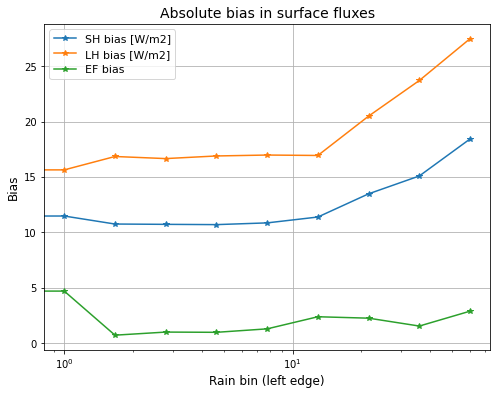

In [43]:
fig, ax1 = plt.subplots(1,1, figsize=(8, 6))

ax1.semilogx(rainBins, absBiasSH_rainBins,'*-',label='SH bias [W/m2]')
ax1.semilogx(rainBins, absBiasLH_rainBins,'*-',label='LH bias [W/m2]')
ax1.semilogx(rainBins, absBiasEF_rainBins,'*-',label='EF bias')
ax1.set_title('Absolute bias in surface fluxes',fontsize=14)
ax1.legend(fontsize=11)
ax1.set_xlabel('Rain bin (left edge)',fontsize=12)
ax1.set_ylabel('Bias',fontsize=12)
ax1.grid()


Now for the monthly break down of rain-bin based biases... 

In [107]:
np.shape(monthlyObsSHmean_rainBins)



/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(116, 12, 11)

In [45]:
# Biases in binary rain classification, this time by month  
#  Considering bias = model - obs 
#  Computing straight bias as well as absolute bias...

# ----- Biases on days that rain vs. don't -----
biasSH_rainBinsMonthly    = np.nanmean(   (monthlyModSHmean_rainBins - monthlyObsSHmean_rainBins), axis=0)
absBiasSH_rainBinsMonthly = np.nanmean(abs(monthlyModSHmean_rainBins - monthlyObsSHmean_rainBins), axis=0)

biasLH_rainBinsMonthly    = np.nanmean(   (monthlyModLHmean_rainBins - monthlyObsLHmean_rainBins), axis=0)
absBiasLH_rainBinsMonthly = np.nanmean(abs(monthlyModLHmean_rainBins - monthlyObsLHmean_rainBins), axis=0)

biasEF_rainBinsMonthly    = np.nanmean(   (monthlyModEFmean_rainBins - monthlyObsEFmean_rainBins), axis=0)
absBiasEF_rainBinsMonthly = np.nanmean(abs(monthlyModEFmean_rainBins - monthlyObsEFmean_rainBins), axis=0)



<ipython-input-45-1472c18afaab>:6: RuntimeWarning: Mean of empty slice
  biasSH_rainBinsMonthly    = np.nanmean(   (monthlyModSHmean_rainBins - monthlyObsSHmean_rainBins), axis=0)


/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0, 0.5, 'Bias [W/m2]')

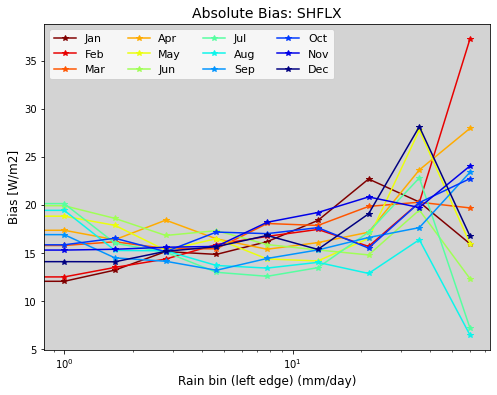

In [128]:
# Plot SH bias throughout the year 
monthLabels=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
colors = plt.cm.jet_r(np.linspace(0,1,12))


fig, ax1 = plt.subplots(1,1, figsize=(8, 6))

for iMon in range(12):
    ax1.semilogx(rainBins, absBiasSH_rainBinsMonthly[iMon,:],'*-',color=colors[iMon], label=monthLabels[iMon])
    
ax1.set_facecolor('lightgrey')
ax1.legend(ncol=4,fontsize=11)
ax1.set_title('Absolute Bias: SHFLX',fontsize=14)
ax1.set_xlabel('Rain bin (left edge) (mm/day)',fontsize=12)
ax1.set_ylabel('Bias [W/m2]',fontsize=12)

In [49]:
DJFinds = np.asarray([11,0,1]).astype(int)
np.shape(absBiasSH_rainBinsMonthly[8:11,:])



(3, 11)

/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-55-6bd47d7d6d60>:5: RuntimeWarning: Mean of empty slice
  absBiasSH_DJF = np.nanmean(absBiasSH_rainBinsMonthly[DJFinds,:],axis=0)


Text(0, 0.5, 'Bias [W/m2]')

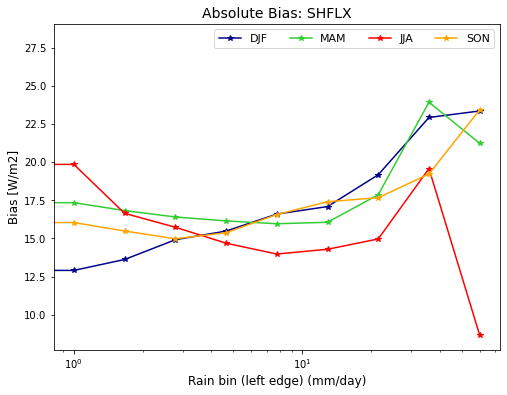

In [55]:
## Seasonal??

# Get those seasonal means:
DJFinds = np.asarray([11,0,1]).astype(int)
absBiasSH_DJF = np.nanmean(absBiasSH_rainBinsMonthly[DJFinds,:],axis=0)
absBiasSH_MAM = np.nanmean(absBiasSH_rainBinsMonthly[2:5,:],axis=0)
absBiasSH_JJA = np.nanmean(absBiasSH_rainBinsMonthly[5:8,:],axis=0)
absBiasSH_SON = np.nanmean(absBiasSH_rainBinsMonthly[8:11,:],axis=0)

# Plot seasonal SH bias 
monthLabels=['DJF','MAM','JJA','SON']
colors = plt.cm.jet_r(np.linspace(0,1,4))


fig, ax1 = plt.subplots(1,1, figsize=(8, 6))

ax1.semilogx(rainBins, absBiasSH_DJF,'*-',color='darkblue', label='DJF')
ax1.semilogx(rainBins, absBiasSH_MAM,'*-',color='limegreen', label='MAM')
ax1.semilogx(rainBins, absBiasSH_JJA,'*-',color='red', label='JJA')
ax1.semilogx(rainBins, absBiasSH_SON,'*-',color='orange', label='SON')
    
#ax1.set_facecolor('lightgrey')
ax1.legend(ncol=4,fontsize=11)
ax1.set_title('Absolute Bias: SHFLX',fontsize=14)
ax1.set_xlabel('Rain bin (left edge) (mm/day)',fontsize=12)
ax1.set_ylabel('Bias [W/m2]',fontsize=12)



/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0, 0.5, 'Bias [W/m2]')

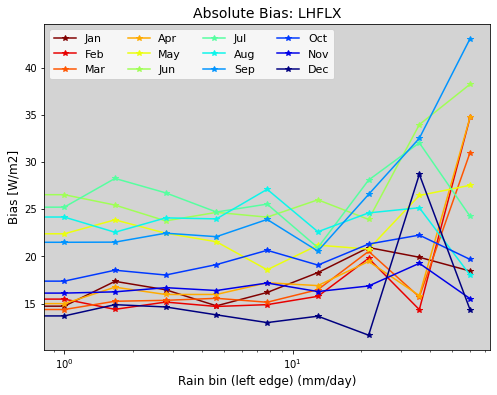

In [129]:
# Plot SH bias throughout the year 
monthLabels=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
colors = plt.cm.jet_r(np.linspace(0,1,12))


fig, ax1 = plt.subplots(1,1, figsize=(8, 6))

for iMon in range(12):
    ax1.semilogx(rainBins, absBiasLH_rainBinsMonthly[iMon,:],'*-',color=colors[iMon], label=monthLabels[iMon])
    
ax1.set_facecolor('lightgrey')
ax1.legend(ncol=4,fontsize=11)
ax1.set_title('Absolute Bias: LHFLX',fontsize=14)
ax1.set_xlabel('Rain bin (left edge) (mm/day)',fontsize=12)
ax1.set_ylabel('Bias [W/m2]',fontsize=12)

/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-56-f11ab942b92e>:5: RuntimeWarning: Mean of empty slice
  absBiasLH_DJF = np.nanmean(absBiasLH_rainBinsMonthly[DJFinds,:],axis=0)


Text(0, 0.5, 'Bias [W/m2]')

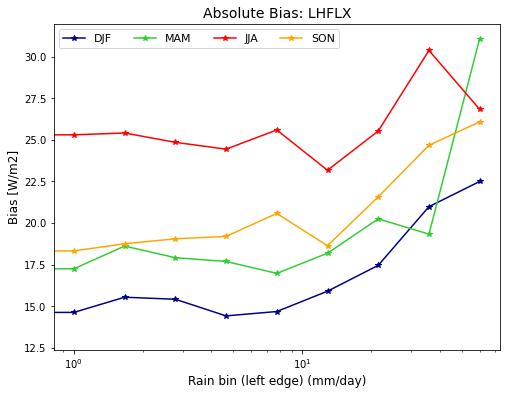

In [56]:
## Seasonal??

# Get those seasonal means:
DJFinds = np.asarray([11,0,1]).astype(int)
absBiasLH_DJF = np.nanmean(absBiasLH_rainBinsMonthly[DJFinds,:],axis=0)
absBiasLH_MAM = np.nanmean(absBiasLH_rainBinsMonthly[2:5,:],axis=0)
absBiasLH_JJA = np.nanmean(absBiasLH_rainBinsMonthly[5:8,:],axis=0)
absBiasLH_SON = np.nanmean(absBiasLH_rainBinsMonthly[8:11,:],axis=0)

# Plot seasonal SH bias 
monthLabels=['DJF','MAM','JJA','SON']
colors = plt.cm.jet_r(np.linspace(0,1,4))


fig, ax1 = plt.subplots(1,1, figsize=(8, 6))

ax1.semilogx(rainBins, absBiasLH_DJF,'*-',color='darkblue', label='DJF')
ax1.semilogx(rainBins, absBiasLH_MAM,'*-',color='limegreen', label='MAM')
ax1.semilogx(rainBins, absBiasLH_JJA,'*-',color='red', label='JJA')
ax1.semilogx(rainBins, absBiasLH_SON,'*-',color='orange', label='SON')
    
#ax1.set_facecolor('lightgrey')
ax1.legend(ncol=4,fontsize=11)
ax1.set_title('Absolute Bias: LHFLX',fontsize=14)
ax1.set_xlabel('Rain bin (left edge) (mm/day)',fontsize=12)
ax1.set_ylabel('Bias [W/m2]',fontsize=12)




/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(0.0, 40.0)

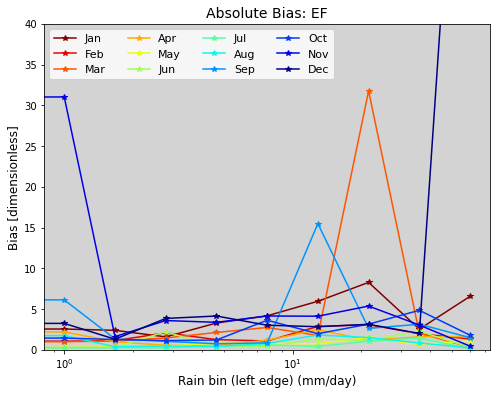

In [131]:
# Plot SH bias throughout the year 
monthLabels=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
colors = plt.cm.jet_r(np.linspace(0,1,12))


fig, ax1 = plt.subplots(1,1, figsize=(8, 6))

for iMon in range(12):
    ax1.semilogx(rainBins, absBiasEF_rainBinsMonthly[iMon,:],'*-',color=colors[iMon], label=monthLabels[iMon])
    
ax1.set_facecolor('lightgrey')
ax1.legend(ncol=4,fontsize=11)
ax1.set_title('Absolute Bias: EF',fontsize=14)
ax1.set_xlabel('Rain bin (left edge) (mm/day)',fontsize=12)
ax1.set_ylabel('Bias [dimensionless]',fontsize=12)

ax1.set_ylim([0,40])


/Users/mdfowler/opt/anaconda3/envs/metPy/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-57-df34ba627b20>:5: RuntimeWarning: Mean of empty slice
  absBiasEF_DJF = np.nanmean(absBiasEF_rainBinsMonthly[DJFinds,:],axis=0)


Text(0, 0.5, 'Bias [W/m2]')

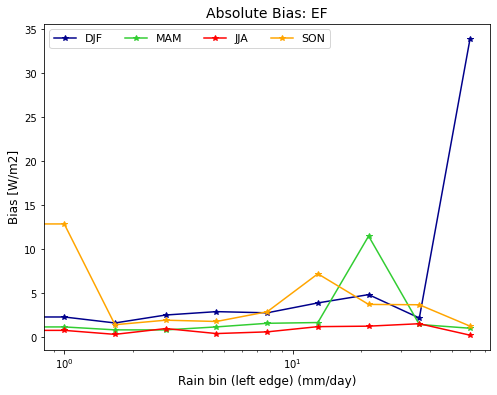

In [57]:
## Seasonal??

# Get those seasonal means:
DJFinds = np.asarray([11,0,1]).astype(int)
absBiasEF_DJF = np.nanmean(absBiasEF_rainBinsMonthly[DJFinds,:],axis=0)
absBiasEF_MAM = np.nanmean(absBiasEF_rainBinsMonthly[2:5,:],axis=0)
absBiasEF_JJA = np.nanmean(absBiasEF_rainBinsMonthly[5:8,:],axis=0)
absBiasEF_SON = np.nanmean(absBiasEF_rainBinsMonthly[8:11,:],axis=0)

# Plot seasonal SH bias 
monthLabels=['DJF','MAM','JJA','SON']
colors = plt.cm.jet_r(np.linspace(0,1,4))


fig, ax1 = plt.subplots(1,1, figsize=(8, 6))

ax1.semilogx(rainBins, absBiasEF_DJF,'*-',color='darkblue', label='DJF')
ax1.semilogx(rainBins, absBiasEF_MAM,'*-',color='limegreen', label='MAM')
ax1.semilogx(rainBins, absBiasEF_JJA,'*-',color='red', label='JJA')
ax1.semilogx(rainBins, absBiasEF_SON,'*-',color='orange', label='SON')
    
#ax1.set_facecolor('lightgrey')
ax1.legend(ncol=4,fontsize=11)
ax1.set_title('Absolute Bias: EF',fontsize=14)
ax1.set_xlabel('Rain bin (left edge) (mm/day)',fontsize=12)
ax1.set_ylabel('Bias [W/m2]',fontsize=12)



## SCRATCH WORK 

Going to use lowest level (assuming this is stability between surface and the first atmo level, since there are an equal number of Ri values returned as there are levels supplied to MetPy). Assume a critical value of 0.25, below which there is assumed to be turbulence. Not sure how to integrate this value across levels... do you need to compute it from scratch, given just PBL top (ish) and sfc (ish)? 

In [88]:
# Critical Richardson value 
Ri_crit = 0.25 

# Make a mask of what days/stations are at this Ri value. 
Ri_mask = np.full([np.shape(model_Ri)[0], np.shape(model_Ri)[1]], np.nan)
Ri_mask[model_Ri[:,:,-1]<=Ri_crit] = 1 

Ri_stablMask = np.full([np.shape(model_Ri)[0], np.shape(model_Ri)[1]], np.nan)
Ri_stablMask[model_Ri[:,:,-1]>=Ri_crit] = 1 


In [104]:
# What do biases look like on days with vs. without much turublence in first level? 
meanBiasSH_turbl   = np.full([len(dataFiles_filter)], np.nan)   # Based on model stability 
meanBiasSH_stabl   = np.full([len(dataFiles_filter)], np.nan)
meanBiasSHLH_turbl = np.full([len(dataFiles_filter)], np.nan)   
meanBiasSHLH_stabl = np.full([len(dataFiles_filter)], np.nan)
meanBiasTS_turbl   = np.full([len(dataFiles_filter)], np.nan)   
meanBiasTS_stabl   = np.full([len(dataFiles_filter)], np.nan)
meanBiasSpd_turbl  = np.full([len(dataFiles_filter)], np.nan)
meanBiasSpd_stabl  = np.full([len(dataFiles_filter)], np.nan)

meanBiasSH_rainy   = np.full([len(dataFiles_filter)], np.nan)   # Based on observations of rain 
meanBiasSH_dry     = np.full([len(dataFiles_filter)], np.nan)
meanBiasSHLH_rainy = np.full([len(dataFiles_filter)], np.nan)  
meanBiasSHLH_dry   = np.full([len(dataFiles_filter)], np.nan)
meanBiasTS_rainy   = np.full([len(dataFiles_filter)], np.nan)  
meanBiasTS_dry     = np.full([len(dataFiles_filter)], np.nan)
meanBiasSpd_rainy  = np.full([len(dataFiles_filter)], np.nan)
meanBiasSpd_dry    = np.full([len(dataFiles_filter)], np.nan)

for iStation in range(len(dataFiles_filter)):
    
    station_Ri     = Ri_mask[iStation,:]
    station_stable = Ri_stablMask[iStation,:]
    
    # Limit model output to 2000-2010 (same as Ri)
    # -------------------------------------------
    iTime = np.where( (modelDS.time.values>=np.datetime64('2000-01-01')) & 
                     (modelDS.time.values<=np.datetime64('2009-12-31')) )[0]
    modelDS = modelDS.isel(time=iTime)
    
    # Also figure out where obs times fall and limit model
    # ----------------------------------------------------
    iStart = pd.DatetimeIndex(startTime_fluxnet_sel)[iStation] 
    iEnd   = pd.DatetimeIndex(endTime_fluxnet_sel)[iStation]

    # Match model data to that date range and pull out selected station
    modelTime = pd.DatetimeIndex(modelDS['time'].values) 
    iTimes    = np.where((modelTime>=iStart) & (modelTime<=iEnd) )[0]
    #modelDS_station = modelDS.isel(time=iTimes,station=stationChoice)
    modelDS_station = modelDS.isel(station=stationChoice)
    
    station_Ri = station_Ri[iTimes]
    station_stable = station_stable[iTimes]
    
    
    # Pull out obs for station and limit to 2000-2009 range too 
    # ---------------------------------------------------------
    iTimes_obs = np.where( (dayRange>=np.datetime64('2000-01-01')) & 
                     (dayRange<=np.datetime64('2009-12-31')) )[0]
    dayRange_sel = dayRange[iTimes_obs]
    iTimes_obs2 = np.where( (dayRange_sel>=iStart) & (dayRange_sel<=iEnd) )[0]
    
    obsSH      = fluxnet_SH[iStation,iTimes_obs2]
    obsLH      = fluxnet_LH[iStation,iTimes_obs2]
    obsTS      = fluxnet_temp_K[iStation,iTimes_obs2]
    obsWind    = fluxnet_spd[iStation,iTimes_obs2]
    obsPrecip  = fluxnet_precip_ms[iStation,iTimes_obs2]
    
    # Define a mask for if *any* precip occurs at station
    precipMask = np.full([len(iTimes_obs2)],np.nan)
    precipMask[obsPrecip>0] = 1 
    dryMask = np.full([len(iTimes_obs2)], np.nan)
    dryMask[obsPrecip==0] = 1
    
    
    
    # Start computing biases [model - obs]
    # -----------------------------------------
    #    Based on rainfall at stations  
    meanBiasSH_rainy[iStation]   = np.nanmean(np.abs((modelDS_station.model_SH.values[iTimes]*precipMask) - 
                                              (obsSH*precipMask)))
    meanBiasSH_dry[iStation]     = np.nanmean(np.abs((modelDS_station.model_SH.values[iTimes]*dryMask) 
                                              - (obsSH*dryMask)))
    
    modelSHLH = modelDS_station.model_SH.values+modelDS_station.model_LH.values
    obsSHLH   = obsSH+obsLH
    meanBiasSHLH_rainy[iStation] = np.nanmean(np.abs((modelSHLH[iTimes]*precipMask) - (obsSHLH*precipMask)))
    meanBiasSHLH_dry[iStation]   = np.nanmean(np.abs((modelSHLH[iTimes]*dryMask) - (obsSHLH*dryMask)))
    
    meanBiasTS_rainy[iStation]   = np.nanmean(np.abs((modelDS_station.model_TS.values[iTimes]*precipMask) - 
                                                     (obsTS*precipMask)))
    meanBiasTS_dry[iStation]     = np.nanmean(np.abs((modelDS_station.model_TS.values[iTimes]*dryMask) - 
                                                     (obsTS*dryMask)))

    meanBiasSpd_rainy[iStation]  = np.nanmean(np.abs((modelDS_station.model_spd.values[iTimes]*precipMask) - 
                                                     (obsWind*precipMask)))
    meanBiasSpd_dry[iStation]    = np.nanmean(np.abs((modelDS_station.model_spd.values[iTimes]*dryMask) - 
                                                     (obsWind*dryMask)))
    
    
    #    Based on stability/turbulence
    meanBiasSH_turbl[iStation]   = np.nanmean(np.abs((modelDS_station.model_SH.values[iTimes]*station_Ri) - 
                                                     (obsSH*station_Ri)))
    meanBiasSH_stabl[iStation]   = np.nanmean(np.abs((modelDS_station.model_SH.values[iTimes]*station_stable) -
                                                     (obsSH*station_stable)))
    
#     modelSHLH = modelDS_station.model_SH.values+modelDS_station.model_LH.values
#     obsSHLH   = obsSH+obsLH
    meanBiasSHLH_turbl[iStation] = np.nanmean(np.abs((modelSHLH[iTimes]*station_Ri) - (obsSHLH*station_Ri)))
    meanBiasSHLH_stabl[iStation] = np.nanmean(np.abs((modelSHLH[iTimes]*station_stable) - (obsSHLH*station_stable)))
    
    meanBiasTS_turbl[iStation]   = np.nanmean(np.abs((modelDS_station.model_TS.values[iTimes]*station_Ri) - 
                                                     (obsTS*station_Ri)))
    meanBiasTS_stabl[iStation]   = np.nanmean(np.abs((modelDS_station.model_TS.values[iTimes]*station_stable) - 
                                                     (obsTS*station_stable)))

    meanBiasSpd_turbl[iStation]  = np.nanmean(np.abs((modelDS_station.model_spd.values[iTimes]*station_Ri) - 
                                                     (obsWind*station_Ri)))
    meanBiasSpd_stabl[iStation]  = np.nanmean(np.abs((modelDS_station.model_spd.values[iTimes]*station_stable) - 
                                                     (obsWind*station_stable)))

    
    
    

<ipython-input-104-52b04335591c>:70: RuntimeWarning: Mean of empty slice
  meanBiasSH_rainy[iStation]   = np.nanmean(np.abs((modelDS_station.model_SH.values[iTimes]*precipMask) -
<ipython-input-104-52b04335591c>:72: RuntimeWarning: Mean of empty slice
  meanBiasSH_dry[iStation]     = np.nanmean(np.abs((modelDS_station.model_SH.values[iTimes]*dryMask)
<ipython-input-104-52b04335591c>:77: RuntimeWarning: Mean of empty slice
  meanBiasSHLH_rainy[iStation] = np.nanmean(np.abs((modelSHLH[iTimes]*precipMask) - (obsSHLH*precipMask)))
<ipython-input-104-52b04335591c>:78: RuntimeWarning: Mean of empty slice
  meanBiasSHLH_dry[iStation]   = np.nanmean(np.abs((modelSHLH[iTimes]*dryMask) - (obsSHLH*dryMask)))
<ipython-input-104-52b04335591c>:80: RuntimeWarning: Mean of empty slice
  meanBiasTS_rainy[iStation]   = np.nanmean(np.abs((modelDS_station.model_TS.values[iTimes]*precipMask) -
<ipython-input-104-52b04335591c>:82: RuntimeWarning: Mean of empty slice
  meanBiasTS_dry[iStation]     = np.nanme

In [105]:
print('Mean absolute bias [model-obs] across stations...\n')
print('        Turbulent      Stable')
print('SH:  %10.4f %13.4f' % (np.nanmean(meanBiasSH_turbl), np.nanmean(meanBiasSH_stabl)) )
print('SHLH:%10.4f %13.4f' % (np.nanmean(meanBiasSHLH_turbl), np.nanmean(meanBiasSHLH_stabl)) )
print('TS:  %10.4f %13.4f' % (np.nanmean(meanBiasTS_turbl), np.nanmean(meanBiasTS_stabl)) )
print('Spd: %10.4f %13.4f' % (np.nanmean(meanBiasSpd_turbl), np.nanmean(meanBiasSpd_stabl)) )
print('')
print('        Rainy           Dry')
print('SH:  %10.4f %13.4f' % (np.nanmean(meanBiasSH_rainy), np.nanmean(meanBiasSH_dry)) )
print('SHLH:%10.4f %13.4f' % (np.nanmean(meanBiasSHLH_rainy), np.nanmean(meanBiasSHLH_dry)) )
print('TS:  %10.4f %13.4f' % (np.nanmean(meanBiasTS_rainy), np.nanmean(meanBiasTS_dry)) )
print('Spd: %10.4f %13.4f' % (np.nanmean(meanBiasSpd_rainy), np.nanmean(meanBiasSpd_dry)) )


Mean absolute bias [model-obs] across stations...

        Turbulent      Stable
SH:     38.0318       38.6237
SHLH:   45.3126       47.1633
TS:      7.3895        7.4935
Spd:     2.8139        2.2902

        Rainy           Dry
SH:     41.4607       35.0743
SHLH:   51.8946       40.7041
TS:      7.9538        6.9427
Spd:     2.6093        2.4821


### Plots?

In [122]:
# --- Set up discrete colorbar ---
import matplotlib as mpl
import matplotlib.cm as cm

cmap = plt.cm.seismic  # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]

# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)

bounds = np.arange(-30, 52, 2)
norm   = mpl.colors.BoundaryNorm(bounds, cmap.N)
m      = cm.ScalarMappable(norm=norm,cmap=cmap)



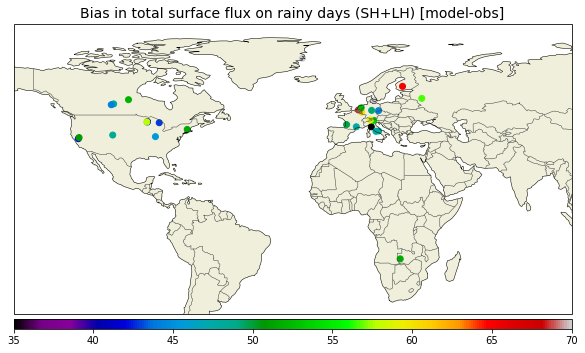

In [155]:
# ---- Maps of correlation coefficients ---- # 
# Set up figure
fig, ax1 = plt.subplots(1,1, figsize=(10, 7),subplot_kw={'projection':ccrs.PlateCarree()})

# Set limits of plot
ax1.set_extent([-150, 100, -40, 90], crs=ccrs.PlateCarree())
# Add coastlines 
ax1.coastlines(linewidth=0.5,edgecolor='0.25')
ax1.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
ax1.add_feature(cfeature.LAND)
ax1.set_title('Bias in total surface flux on rainy days (SH+LH) [model-obs]', fontsize=14)

p = ax1.scatter(lon_fluxnet, lat_fluxnet, c=meanBiasSHLH_rainy,transform=ccrs.PlateCarree(),
               cmap='nipy_spectral',vmax=70,edgecolors='face')

ax_position = ax1.get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.03, ax_position.width, 0.02])
cbar        = plt.colorbar(p, orientation='horizontal', cax=cbar_ax)


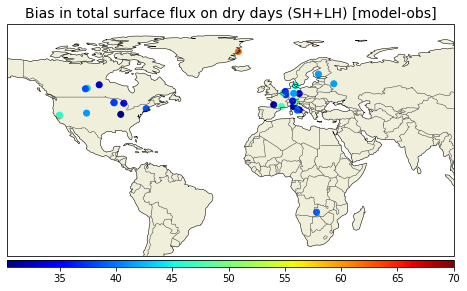

In [156]:
# ---- Maps of correlation coefficients ---- # 
# Set up figure
fig, ax1 = plt.subplots(1,1, figsize=(8, 5),subplot_kw={'projection':ccrs.PlateCarree()})

# Set limits of plot
ax1.set_extent([-150, 100, -40, 90], crs=ccrs.PlateCarree())

# Add coastlines 
ax1.coastlines(linewidth=0.5,edgecolor='0.25')
ax1.add_feature(cfeature.LAND)
ax1.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
ax1.set_title('Bias in total surface flux on dry days (SH+LH) [model-obs]', fontsize=14)

p = ax1.scatter(lon_fluxnet, lat_fluxnet, c=meanBiasSHLH_dry,transform=ccrs.PlateCarree(),
               cmap='jet',vmax=70,edgecolors='face')

ax_position = ax1.get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.03, ax_position.width, 0.02])
cbar        = plt.colorbar(p, orientation='horizontal', cax=cbar_ax)



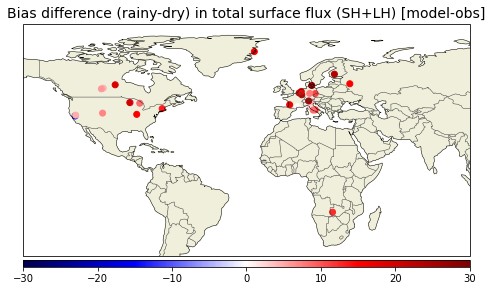

In [158]:
# ---- Maps of correlation coefficients ---- # 
# Set up figure
fig, ax1 = plt.subplots(1,1, figsize=(8, 5),subplot_kw={'projection':ccrs.PlateCarree()})

# Set limits of plot
ax1.set_extent([-150, 100, -40, 90], crs=ccrs.PlateCarree())

# Add coastlines 
ax1.coastlines(linewidth=0.5,edgecolor='0.25')
ax1.add_feature(cfeature.LAND)
ax1.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
ax1.set_title('Bias difference (rainy-dry) in total surface flux (SH+LH) [model-obs]', fontsize=14)

p = ax1.scatter(lon_fluxnet, lat_fluxnet, c=(meanBiasSHLH_rainy-meanBiasSHLH_dry) ,transform=ccrs.PlateCarree(),
               cmap='seismic',vmin=-30,vmax=30,edgecolors='face')

ax_position = ax1.get_position()
cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.03, ax_position.width, 0.02])
cbar        = plt.colorbar(p, orientation='horizontal', cax=cbar_ax)




In [159]:
len(np.where(np.isfinite(meanBiasSHLH_rainy)==True)[0])

29

(10957.0, 11323.0)

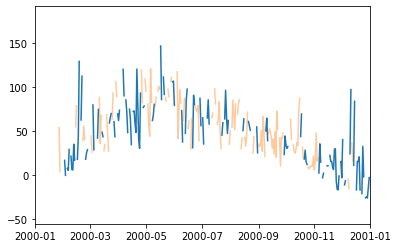

In [45]:
#plt.plot(modelDS_station.time,modelDS_station.model_SH)
plt.plot(modelDS_station.time,modelDS_station.model_SH*station_Ri)
plt.plot(modelDS_station.time,modelDS_station.model_SH*Ri_stablMask[iStation,:],alpha=0.4)
plt.xlim(np.datetime64('2000-01-01'), np.datetime64('2001-01-01'))


In [48]:
np.where(fluxnet_precip_ms[iStation,:]>0)

(array([   4,    5,    6, ..., 8031, 8033, 8034]),)